## Import

In [1]:
# Import all the functions you need
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
import os
from pathlib import Path
import platform

# Comment here to add in for either mac or linux computer
if platform.system() == "Linux":   # for linux
    sys.path.extend(['/data/GitHub/NeuroPy']) 
    sys.path.extend(['/data/GitHub/TraceFC/'])
elif platform.system() == "Darwin":
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/NeuroPy'])
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/TraceFC'])
elif platform.system() == "Windows":
    print('No windows repositories defined')

from neuropy import core
from neuropy.io import (optitrackio,
                        dlcio,
                        )
from neuropy.io.miniscopeio import MiniscopeIO
from neuropy.core import Epoch
from neuropy.utils import plot_util
from neuropy.utils.signal_process import WaveletSg
from neuropy.plotting.spikes import plot_raster, plot_binned_raster
from neuropy.plotting.signals import plot_signal_w_epochs, plot_spectrogram

from tracefc.io.session_directory import get_session_dir

In [2]:
# Define a class for a typical recording or set of recordings
from neuropy.core.session import ProcessData
    
def sess_use(basepath=os.getcwd()):

    return ProcessData(basepath)

In [3]:
animal, sess_name = 'Django', 'training'
sess_dir = get_session_dir(animal, sess_name)
sess = sess_use(sess_dir)
print(sess.recinfo)

filename: /data3/Trace_FC/Recording_Rats/Django/2023_03_08_training/Django_training_denoised.xml 
# channels: 134
sampling rate: 30000
lfp Srate (downsampled): 1250



In [4]:
print(sess.eegfile)

duration: 20579.90 seconds 
duration: 5.72 hours 



# Preprocess Ephys data
Identify artifacts:  
- disconnects  
- filtering  
  
Send to event files to check in Neuroscope  
Write `dead_times.txt` file for spyking-circus and `artifacts.npy` file for my own analysis.

### Identify disconnect and motion artifacts

In [5]:
from neuropy.analyses.artifact import detect_artifact_epochs
signal = sess.eegfile.get_signal()
buffer_add = 0.25  # seconds, None = don't add

art_epochs_file = sess.filePrefix.with_suffix(".art_epochs.npy")
if art_epochs_file.exists():
    art_epochs = Epoch(epochs=None, file=art_epochs_file)
    print('Existing artifact epochs file loaded')
else:
    # art_epochs = detect_artifact_epochs(signal, thresh=8, 
    #                                 edge_cutoff=3, merge=6)

    # Pick a particular channel with the code below
    art_epochs = detect_artifact_epochs(signal.time_slice(channel_id=59), thresh=8, 
                                    edge_cutoff=3, merge=6)

    if buffer_add is not None:  # Add in buffer to prevent erroneous detection of start/stop of artifact as SWRs
        art_epochs.add_epoch_buffer(buffer_add)
    sess.recinfo.write_epochs(epochs=art_epochs, ext='art')
    art_epochs.save(art_epochs_file)

print(f'Total artifact time = {art_epochs.durations.sum():0.1F} seconds')
art_epochs.to_dataframe()

Existing artifact epochs file loaded
Total artifact time = 15.9 seconds


/home/bowenw/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


start        stop label  duration
0    729.2412    729.9500  None    0.7088
1   1097.3612   1099.2852  None    1.9240
2   1382.4284   1383.8692  None    1.4408
3   1672.6000   1674.1000  None    1.5000
4   1952.6188   1954.1436  None    1.5248
5   2220.3684   2221.7436  None    1.3752
6   2499.3000   2500.7500  None    1.4500
7   9356.3572   9361.7388  None    5.3816
8  15761.5868  15762.1756  None    0.5888

<Axes: >

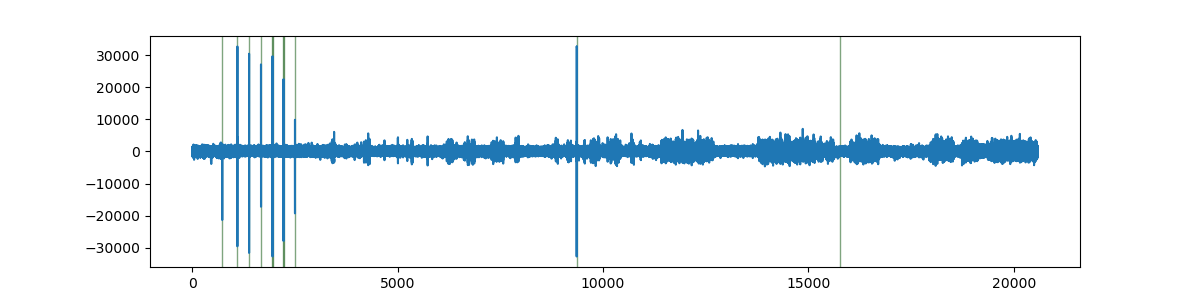

In [6]:
%matplotlib widget

chan_plot = 25
plot_signal_w_epochs(signal, chan_plot, art_epochs)

## Define probe group

/data3/Trace_FC/Recording_Rats/Django/2023_03_08_training/Django_training_denoised.probegroup.npy saved


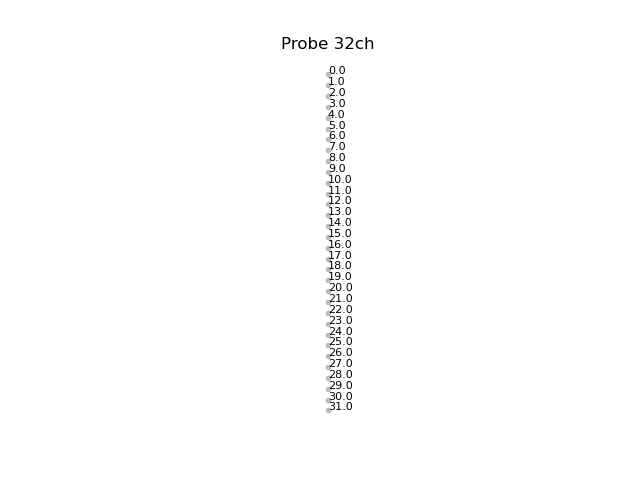

In [7]:
from neuropy.core import Shank, Probe, ProbeGroup
from neuropy.plotting import plot_probe
shank = Shank()
shank = shank.auto_generate(columns=1, contacts_per_column=32, xpitch=0,
                   ypitch=50, channel_id=np.arange(31, -1, -1))
shank.set_disconnected_channels(sess.recinfo.skipped_channels)
probe = Probe(shank)
prbgrp = ProbeGroup()
prbgrp.add_probe(probe)
plot_probe(prbgrp)
prbgrp.filename = sess.filePrefix.with_suffix(".probegroup.npy")
prbgrp.save(prbgrp.filename)
sess.prbgrp = prbgrp

# Detect Theta epochs

In [8]:
from neuropy.analyses.oscillations import detect_theta_epochs
mindur=1
maxdur=20
thresh = (1, None)
sigma = 0.125
edge_cutoff = 0.25
theta_channel = 59

# use this if you don't know theta channel
if theta_channel is None:
    theta_epochs, theta_power = detect_theta_epochs(signal, prbgrp, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)
else:
    signal_use = signal.time_slice(channel_id=theta_channel)
    theta_epochs, theta_power = detect_theta_epochs(signal_use, probegroup=None, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)
sess.recinfo.write_epochs(theta_epochs, ext='tha')
theta_epochs_file = sess.filePrefix.with_suffix(".theta_epochs.npy")
theta_epochs.save(theta_epochs_file)

Best channel for theta: [59]
1511 epochs remaining with durations within (1,20)
/data3/Trace_FC/Recording_Rats/Django/2023_03_08_training/Django_training_denoised.theta_epochs.npy saved


In [9]:
theta_power.shape

(25724875,)

<Axes: >

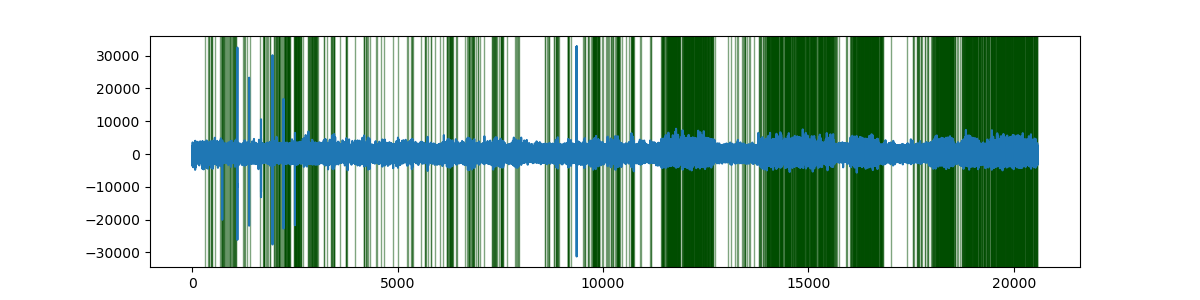

In [10]:
%matplotlib widget

chan_plot = theta_channel
plot_signal_w_epochs(signal, chan_plot, theta_epochs)

## Detect Theta Phase with Hilbert

In [11]:
from neuropy.utils.signal_process import theta_phase_specfic_extraction, ThetaParams

In [12]:
tparams = ThetaParams(lfp=signal.traces[theta_channel,:], fs=signal.sampling_rate, method="hilbert")

(-4000.0, 4000.0)

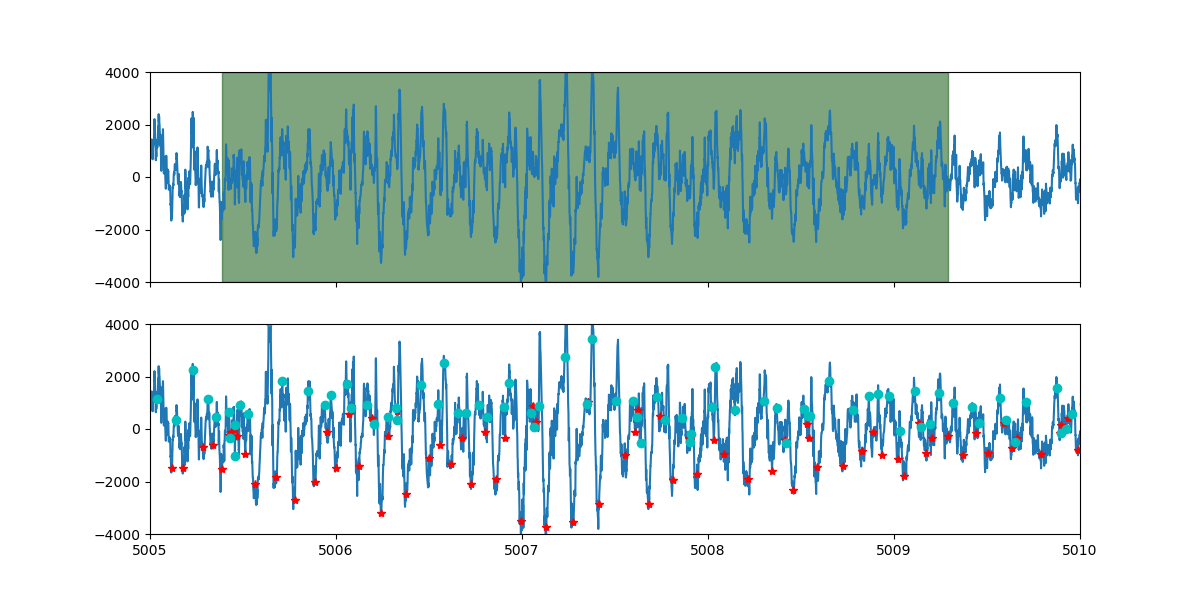

In [13]:
_, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True, sharey=True)
plot_signal_w_epochs(signal, chan_plot, theta_epochs, ax=ax[0])
ax[1].plot(signal.time, signal.traces[theta_channel])
ax[1].plot(signal.time[tparams.trough], signal.traces[theta_channel, tparams.trough], 'r*')
ax[1].plot(signal.time[tparams.peak], signal.traces[theta_channel, tparams.peak], 'co')
ax[0].set_xlim((5005, 5010))
ax[1].set_ylim((-4000, 4000))

## Detect Theta Phase with waveshape

In [14]:
from neuropy.utils.signal_process import hilbert_amplitude_stat, theta_phase_specfic_extraction, ThetaParams

In [15]:
tparams = ThetaParams(lfp=signal.traces[theta_channel, :], fs=signal.sampling_rate, method="waveshape")
trough_indices = tparams.trough.astype(int)
peak_indices = tparams.peak.astype(int)

(-4000.0, 4000.0)

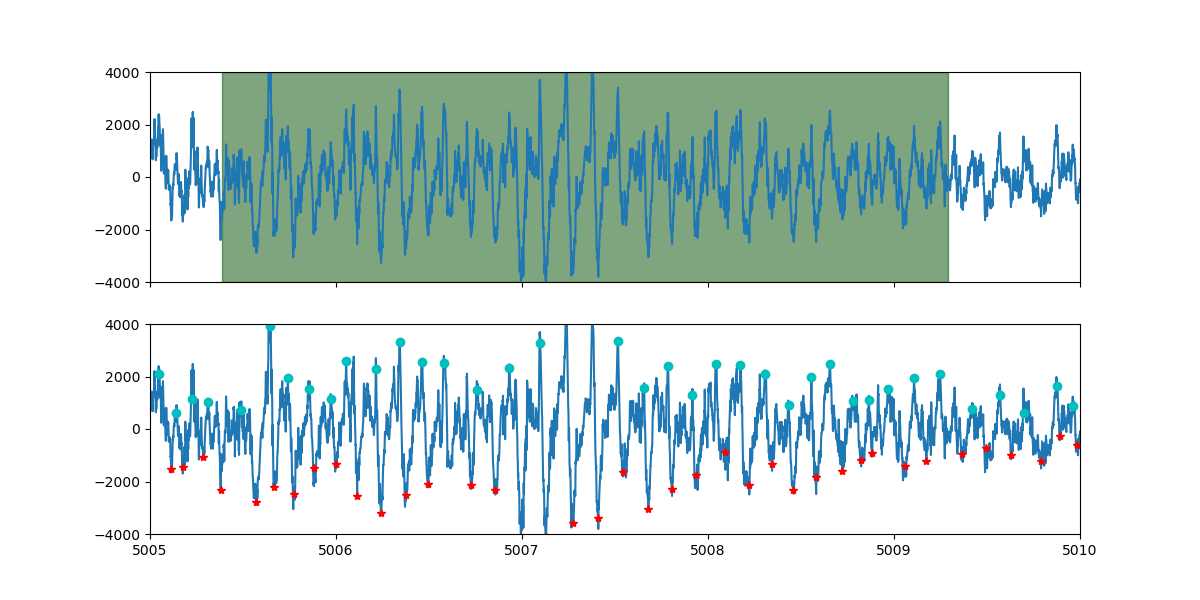

In [16]:
_, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True, sharey=True)
plot_signal_w_epochs(signal, chan_plot, theta_epochs, ax=ax[0])
ax[1].plot(signal.time, signal.traces[theta_channel])

ax[1].plot(signal.time[trough_indices], signal.traces[theta_channel, trough_indices], 'r*')
ax[1].plot(signal.time[peak_indices], signal.traces[theta_channel, peak_indices], 'co')

ax[0].set_xlim((5005, 5010))
ax[1].set_ylim((-4000, 4000))

(-4000.0, 4000.0)

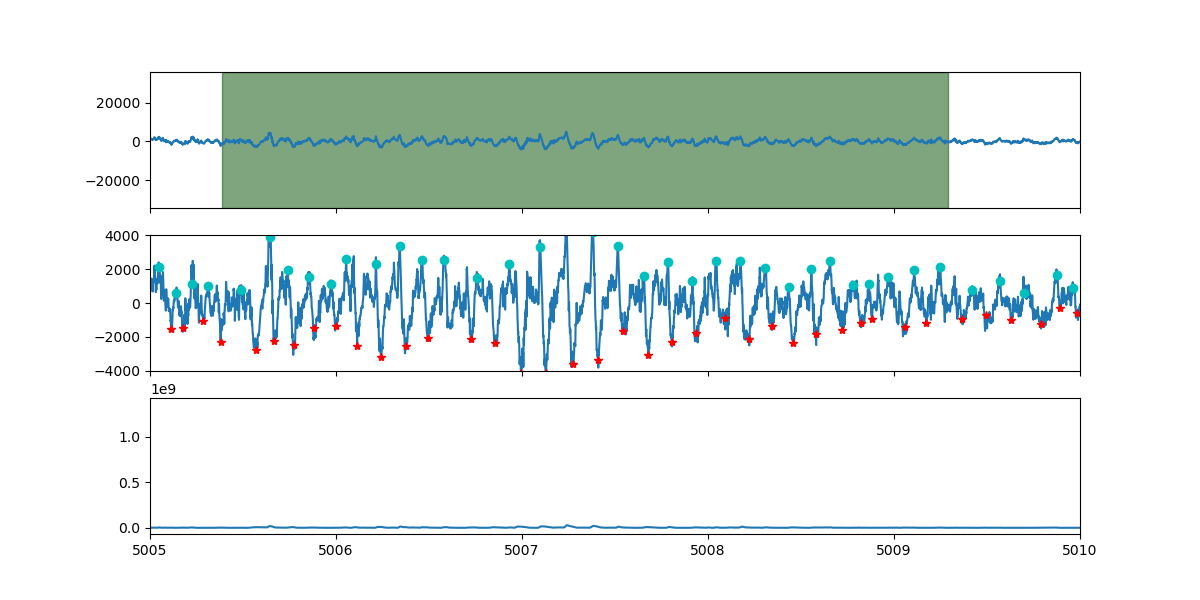

In [17]:
_, ax = plt.subplots(3, 1, figsize=(12, 6), sharex=True, sharey=False)
plot_signal_w_epochs(signal, chan_plot, theta_epochs, ax=ax[0])
ax[1].plot(signal.time, signal.traces[theta_channel])

ax[1].plot(signal.time[trough_indices], signal.traces[theta_channel, trough_indices], 'r*')
ax[1].plot(signal.time[peak_indices], signal.traces[theta_channel, peak_indices], 'co')

ax[2].plot(signal.time, tparams.amp)

ax[0].set_xlim((5005, 5010))
ax[1].set_ylim((-4000, 4000))

In [18]:
signal.traces[theta_channel, :]

memmap([  574,  1141,   922, ..., -1272, -1168, -1059], dtype=int16)

## Import USVs

In [19]:
# Import USV epochs (from Sync_USV_and_Ephys notebook).
usv_epochs_file = sess.filePrefix.with_suffix(".usv_epochs.npy")
usv_epochs = Epoch(epochs=None, file=usv_epochs_file)
usv_epochs


299 epochs
Snippet: 
          start         stop  Begin_Time   Freq_Min  Duration  Freq_Range  \
0  1099.471268  1099.554172  479.631519  37.931231  0.082915   25.781799   
1  1099.749291  1099.833033  479.909576  43.574457  0.083752   21.466391   
2  1100.246300  1100.312456  480.406645  41.472079  0.066164   19.585315   
3  1100.754614  1100.810833  480.915020  39.369700  0.056226   17.261634   
4  1101.555849  1101.651803  481.716352  34.722337  0.095966   20.359876   

   Score  Accept label  
0    1.0       1        
1    1.0       1        
2    1.0       1        
3    1.0       1        
4    1.0       1        

## Figure out theta phase angle of each call start

In [20]:
theta_epochs.contains(usv_epochs.stops)

(array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
      

<Axes: ylabel='Count'>

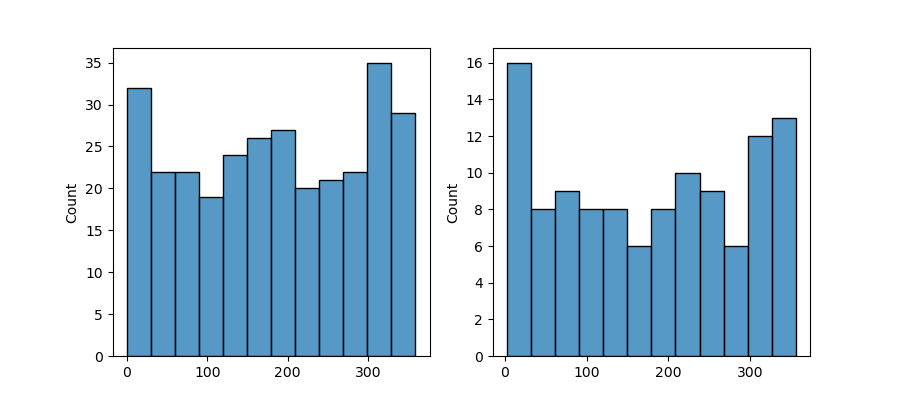

In [21]:
# First get frame number of each usv.
usv_start_frames = (usv_epochs.starts * tparams.fs).astype(int)
usv_start_frames

# Get theta power for each call start
# high_theta_usv_start_times = theta_epochs.contains(usv_epochs.starts)  # This might be too conservative
usv_start_theta_power = theta_power[usv_start_frames]

# Only include calls with above average theta power
theta_thresh = 0  # units = std (theta power is z-scored)
high_usv_power_bool = usv_start_theta_power > theta_thresh
high_theta_usv_start_frames = usv_start_frames[high_usv_power_bool]

# Next, calculate theta phase angle at each usv start
phase_start = tparams.angle[usv_start_frames]
high_theta_phase_start = tparams.angle[high_theta_usv_start_frames]

# Plot histogram of usv start angles
_, ax = plt.subplots(1, 2, figsize=(9, 4))
sns.histplot(phase_start, binwidth=30, ax=ax[0])
sns.histplot(high_theta_phase_start, binwidth=30, ax=ax[1])


In [22]:
low_usv_epochs = usv_epochs._epochs[usv_epochs._epochs.Freq_Min<=23]
low_usv_epochs

start         stop   Begin_Time   Freq_Min  Duration  Freq_Range  \
63   1385.260982  1386.517366   765.455615  16.680464  1.256535   16.179912   
64   1386.595436  1387.111989   766.790230  16.208057  0.516615    9.566225   
65   1387.175823  1387.671112   767.370687  14.672737  0.495348   10.983444   
66   1387.730032  1387.919642   767.924963  16.680464  0.189632    8.030905   
67   1387.974406  1388.446657   768.169366  16.680464  0.472308    8.857616   
..           ...          ...          ...        ...       ...         ...   
294  2235.404953  2235.847877  1615.701863  16.277778  0.442977    7.666667   
295  2235.905064  2236.316906  1616.202034  17.375613  0.411892    7.474265   
296  2236.384538  2236.808221  1616.681566  15.579628  0.423734    9.516029   
297  2236.878080  2237.401800  1617.175167  17.166667  0.523783    7.597036   
298  2237.488905  2237.812043  1617.786066  16.464840  0.323177    6.639090   

     Score  Accept label  
63     1.0       1        
64     1.0       1        
65     1.0       1        
66     1.0       1        
67     1.0       1        
..     ...     ...   ...  
294    1.0       1        
295    1.0       1        
296    1.0       1        
297    1.0       1        
298    1.0       1        

[231 rows x 9 columns]

In [23]:
high_usv_epochs = usv_epochs._epochs[usv_epochs._epochs.Freq_Min>23]
high_usv_epochs

start         stop   Begin_Time   Freq_Min  Duration  Freq_Range  \
0    1099.471268  1099.554172   479.631519  37.931231  0.082915   25.781799   
1    1099.749291  1099.833033   479.909576  43.574457  0.083752   21.466391   
2    1100.246300  1100.312456   480.406645  41.472079  0.066164   19.585315   
3    1100.754614  1100.810833   480.915020  39.369700  0.056226   17.261634   
4    1101.555849  1101.651803   481.716352  34.722337  0.095966   20.359876   
..           ...          ...          ...        ...       ...         ...   
215  1686.915891  1687.044853  1067.146815  39.922958  0.128978   13.167528   
244  1956.043284  1956.159686  1336.306586  41.804033  0.116415   13.499483   
245  1956.367969  1956.461392  1336.631309  43.685109  0.093434   10.954498   
246  1956.585095  1956.652089  1336.848462  40.144261  0.067002   18.368149   
247  1956.884473  1956.971565  1337.147875  41.693382  0.087102   15.380558   

     Score  Accept label  
0      1.0       1        
1      1.0       1        
2      1.0       1        
3      1.0       1        
4      1.0       1        
..     ...     ...   ...  
215    1.0       1        
244    1.0       1        
245    1.0       1        
246    1.0       1        
247    1.0       1        

[68 rows x 9 columns]

## Phase plot at low USV start

<Axes: ylabel='Count'>

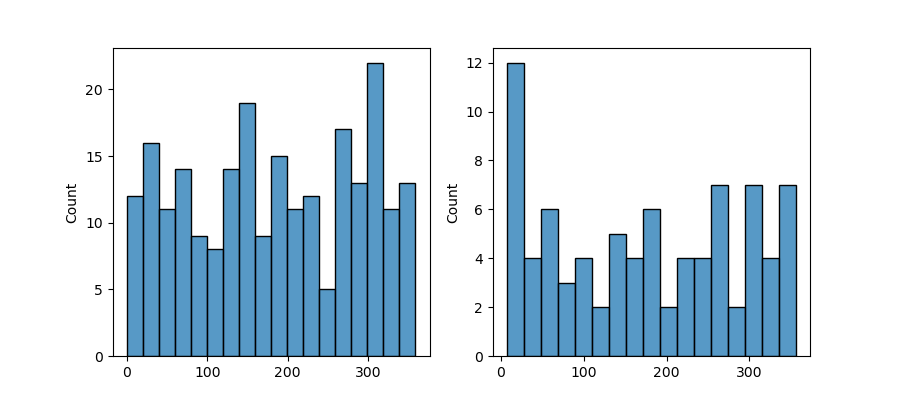

In [24]:
#Histogram for low USVs
# First get frame number of each usv.
lowusv_epochs = usv_epochs._epochs[usv_epochs._epochs.Freq_Min<=23]
lowusv_epochs
lowusv_start_frames = (lowusv_epochs.start * tparams.fs).astype(int)
lowusv_start_frames

# Get theta power for each call start
# high_theta_usv_start_times = theta_epochs.contains(usv_epochs.starts)  # This might be too conservative
lowusv_start_theta_power = theta_power[lowusv_start_frames]

# Only include calls with above average theta power
theta_thresh = 0  # units = std (theta power is z-scored)
lowusv_high_usv_power_bool = lowusv_start_theta_power > theta_thresh
lowusv_high_theta_usv_start_frames = lowusv_start_frames[lowusv_high_usv_power_bool]

# Next, calculate theta phase angle at each usv start
lowusv_phase_start = tparams.angle[lowusv_start_frames]
lowusv_high_theta_phase_start = tparams.angle[lowusv_high_theta_usv_start_frames]

# Plot histogram of usv start angles
_, ax = plt.subplots(1, 2, figsize=(9, 4))
sns.histplot(lowusv_phase_start, binwidth=20, ax=ax[0])
sns.histplot(lowusv_high_theta_phase_start, binwidth=20, ax=ax[1])

In [25]:
lowusv_epochs

start         stop   Begin_Time   Freq_Min  Duration  Freq_Range  \
63   1385.260982  1386.517366   765.455615  16.680464  1.256535   16.179912   
64   1386.595436  1387.111989   766.790230  16.208057  0.516615    9.566225   
65   1387.175823  1387.671112   767.370687  14.672737  0.495348   10.983444   
66   1387.730032  1387.919642   767.924963  16.680464  0.189632    8.030905   
67   1387.974406  1388.446657   768.169366  16.680464  0.472308    8.857616   
..           ...          ...          ...        ...       ...         ...   
294  2235.404953  2235.847877  1615.701863  16.277778  0.442977    7.666667   
295  2235.905064  2236.316906  1616.202034  17.375613  0.411892    7.474265   
296  2236.384538  2236.808221  1616.681566  15.579628  0.423734    9.516029   
297  2236.878080  2237.401800  1617.175167  17.166667  0.523783    7.597036   
298  2237.488905  2237.812043  1617.786066  16.464840  0.323177    6.639090   

     Score  Accept label  
63     1.0       1        
64     1.0       1        
65     1.0       1        
66     1.0       1        
67     1.0       1        
..     ...     ...   ...  
294    1.0       1        
295    1.0       1        
296    1.0       1        
297    1.0       1        
298    1.0       1        

[231 rows x 9 columns]

## Phase plot at high USV start

<Axes: ylabel='Count'>

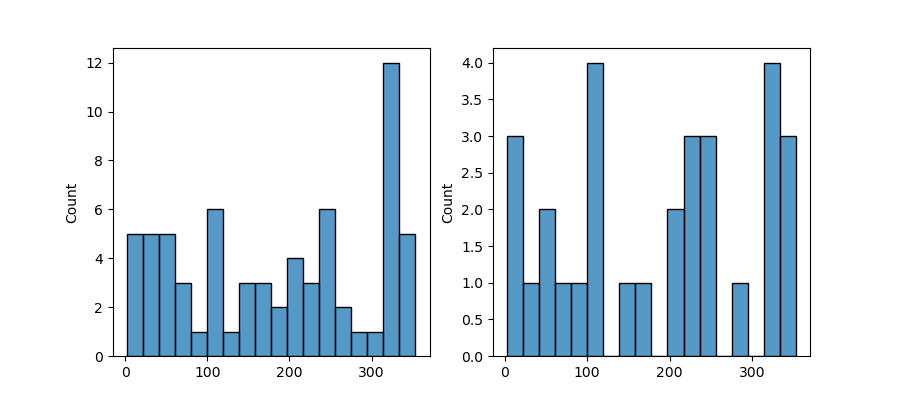

In [26]:
#Histogram for high USVs
# First get frame number of each usv.
highusv_epochs = usv_epochs._epochs[usv_epochs._epochs.Freq_Min>23]
highusv_epochs
highusv_start_frames = (highusv_epochs.start * tparams.fs).astype(int)
highusv_start_frames

# Get theta power for each call start
# high_theta_usv_start_times = theta_epochs.contains(usv_epochs.starts)  # This might be too conservative
highusv_start_theta_power = theta_power[highusv_start_frames]

# Only include calls with above average theta power
theta_thresh = 0  # units = std (theta power is z-scored)
highusv_high_usv_power_bool = highusv_start_theta_power > theta_thresh
highusv_high_theta_usv_start_frames = highusv_start_frames[highusv_high_usv_power_bool]

# Next, calculate theta phase angle at each usv start
highusv_phase_start = tparams.angle[highusv_start_frames]
highusv_high_theta_phase_start = tparams.angle[highusv_high_theta_usv_start_frames]

# Plot histogram of usv start angles
_, ax = plt.subplots(1, 2, figsize=(9, 4))
sns.histplot(highusv_phase_start, binwidth=20, ax=ax[0])
sns.histplot(highusv_high_theta_phase_start, binwidth=20, ax=ax[1])

In [27]:
highusv_high_theta_phase_start

array([ 64.52830189, 353.16455696, 288.94736842,  47.64705882,
       231.70212766, 253.63636364, 318.31578947, 328.7755102 ,
        10.71428571, 148.76033058, 329.36170213, 334.58823529,
       110.5511811 ,   3.        , 318.91304348, 220.64516129,
        46.04651163, 115.2       , 238.99159664, 252.91139241,
         5.71428571,  90.        , 225.88235294, 158.82352941,
       202.81690141, 112.8       , 109.45945946, 345.34883721,
       204.14634146,  33.75      ])

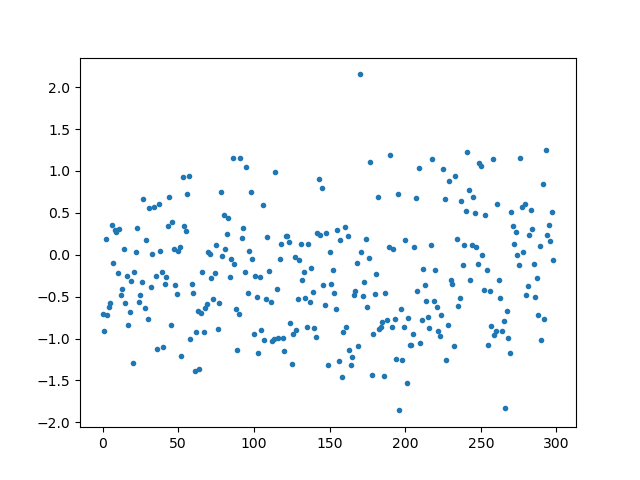

In [28]:
_, ax = plt.subplots()
ax.plot(usv_start_theta_power, '.')

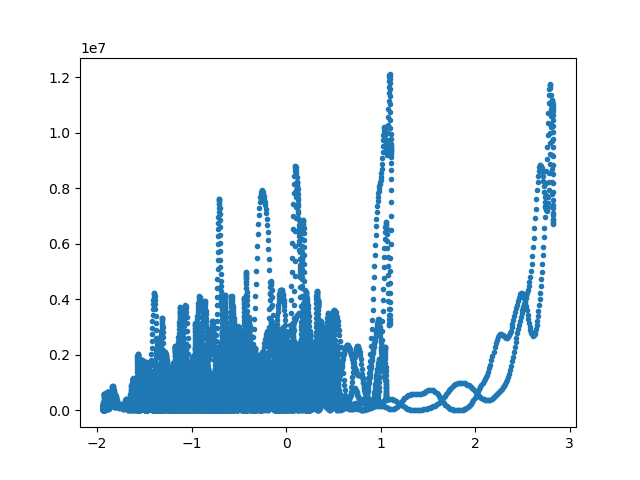

In [29]:
_, ax = plt.subplots()
ax.plot(theta_power[0:30000], tparams.amp[0:30000], '.')

In [30]:
usv_start_theta_power = theta_power[usv_start_frames]
usv_start_theta_power.mean()

-0.23421671233650448

In [31]:
# Only include usvs with high theta power
theta_epochs.contains(np.array([320.4,  321.6, 417]))

(array([ True, False,  True]),
 array([320.4, 417. ]),
 array(['', ''], dtype=object))

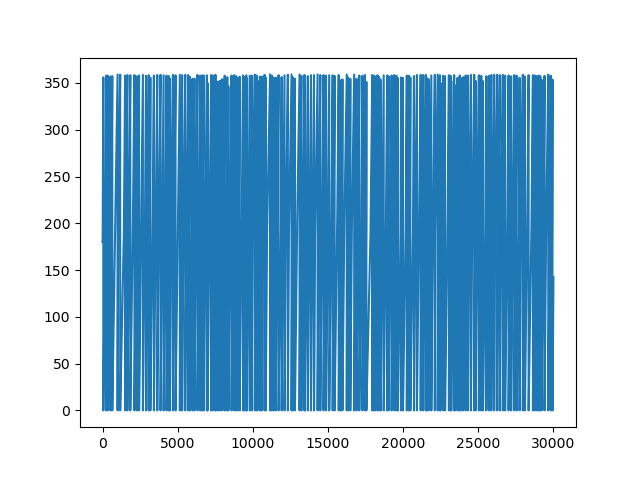

In [32]:
_, ax = plt.subplots()
ax.plot(tparams.angle[0:30000])

In [33]:
usv_epochs.starts

array([1099.47126757, 1099.74929107, 1100.24629996, 1100.75461402,
       1101.55584918, 1101.93558584, 1102.45185539, 1102.82199512,
       1103.47518287, 1104.1028293 , 1104.52363295, 1105.28652274,
       1105.64368245, 1106.87958708, 1107.85318297, 1110.17388797,
       1111.41591246, 1111.90538456, 1112.35667472, 1112.99356507,
       1113.31052861, 1114.5951431 , 1118.54608145, 1119.06360713,
       1120.194458  , 1121.95362431, 1122.84896669, 1123.43976664,
       1124.85584889, 1126.92958838, 1127.85181469, 1129.99311167,
       1131.70042785, 1133.52911363, 1135.27066007, 1138.39589639,
       1138.95989889, 1139.60868722, 1140.3879067 , 1140.88549653,
       1142.08977352, 1143.48406137, 1144.20968597, 1144.84989371,
       1145.21027092, 1146.36550741, 1153.32782533, 1154.14012292,
       1154.83350684, 1156.85838222, 1179.66720265, 1189.95909681,
       1204.44814099, 1227.83393728, 1234.56763305, 1248.88500608,
       1249.99626268, 1253.00485357, 1253.77695499, 1264.84456

## Compare theta power of usv and non-usv

In [34]:
usv_epochs

299 epochs
Snippet: 
          start         stop  Begin_Time   Freq_Min  Duration  Freq_Range  \
0  1099.471268  1099.554172  479.631519  37.931231  0.082915   25.781799   
1  1099.749291  1099.833033  479.909576  43.574457  0.083752   21.466391   
2  1100.246300  1100.312456  480.406645  41.472079  0.066164   19.585315   
3  1100.754614  1100.810833  480.915020  39.369700  0.056226   17.261634   
4  1101.555849  1101.651803  481.716352  34.722337  0.095966   20.359876   

   Score  Accept label  
0    1.0       1        
1    1.0       1        
2    1.0       1        
3    1.0       1        
4    1.0       1        

In [35]:
usv_epochs.stops[0]

1099.554172169983

In [36]:
signal.duration

20579.9

In [37]:
signal.time_slice(t_start=usv_epochs.starts[0], t_stop=usv_epochs.stops[0])

In [38]:
theta_power_sg = core.signal.Signal(theta_power, signal.sampling_rate)

In [39]:
theta_power.min()

-2.484611450389258

In [40]:
theta_power

array([-0.63750656, -0.63750346, -0.63749725, ..., -1.67637289,
       -1.6764369 , -1.67646891])

In [41]:
theta_power.mean()

2.01212538673446e-15

## Calculate theta power during USV/nonUSV

In [42]:
theta_power_usvs, theta_power_non_usvs = [], []
theta_power_sg = core.signal.Signal(theta_power, signal.sampling_rate)
for usv_epoch, usv_next_epoch in zip(usv_epochs, usv_epochs[1:]):

    power_slice = theta_power_sg.time_slice(t_start=usv_epoch.starts, t_stop=usv_epoch.stops)
    theta_power_usvs.append(power_slice.traces[0].mean())

    power_slice = theta_power_sg.time_slice(t_start=usv_epoch.starts, t_stop=usv_next_epoch.starts)

    theta_power_non_usvs.append(power_slice.traces[0].mean())

theta_power_usvs = np.array(theta_power_usvs)
theta_power_non_usvs = np.array(theta_power_non_usvs)

In [43]:
# Make above into pandas DataFrame for easy plotting with seaborn

df1 = pd.DataFrame({"Theta Power": theta_power_usvs, "Epoch": "High USV"})
df2 = pd.DataFrame({"Theta Power": theta_power_non_usvs, "Epoch": "non-USV"})
theta_power_df = pd.concat((df1, df2), axis=0).reset_index()
theta_power_df

index  Theta Power     Epoch
0        0    -0.742158  High USV
1        1    -0.828446  High USV
2        2     0.083340  High USV
3        3    -0.585948  High USV
4        4    -0.585839  High USV
..     ...          ...       ...
591    293     0.666404   non-USV
592    294     0.270710   non-USV
593    295     0.123126   non-USV
594    296     0.589709   non-USV
595    297    -0.434671   non-USV

[596 rows x 3 columns]

In [44]:
theta_power_non_usvs.mean()

-0.24321804541732592

In [45]:
theta_power_usvs.mean()

-0.25324489734616773

<Axes: xlabel='Epoch', ylabel='Theta Power'>

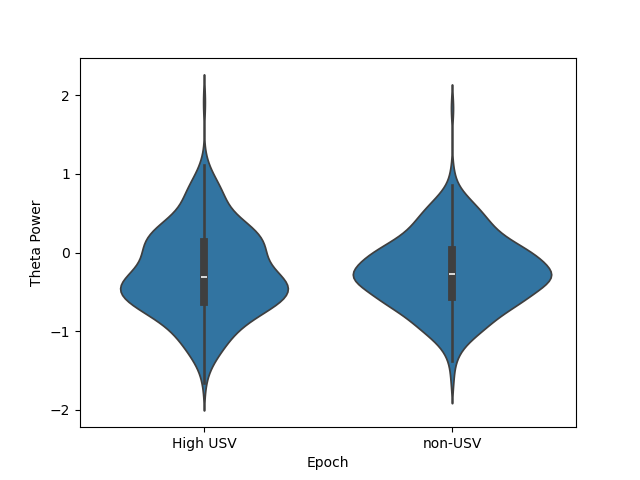

In [46]:
# Easily plot with seaborn
_, ax = plt.subplots()

sns.violinplot(data=theta_power_df, x="Epoch", y="Theta Power")

In [47]:
theta_power_sg

## Calaulate theta power during USV/nonUSV/highUSV/lowUSV

In [48]:
recording_duration = 3000 
theta_power_usvs = []
theta_power_non_usvs = []
theta_power_highusvs = [] 
theta_power_lowusvs = []

for i, usv_epoch in enumerate(usv_epochs):
    if usv_epoch.stops > recording_duration:

        usv_epoch.stops = recording_duration
    

    power_slice = theta_power_sg.time_slice(t_start=usv_epoch.starts, t_stop=min(usv_epoch.stops, recording_duration))
    theta_power_usvs.append(power_slice.traces[0].mean())


    next_start = usv_epochs[i+1].starts if i+1 < len(usv_epochs) else recording_duration

    if usv_epoch.stops < next_start and (next_start - usv_epoch.stops) > 1:
        power_slice = theta_power_sg.time_slice(t_start=usv_epoch.stops, t_stop=next_start)
        theta_power_non_usvs.append(power_slice.traces[0].mean())

    if usv_epoch.to_dataframe()['Freq_Min'].values[0] > 23:

        power_slice = theta_power_sg.time_slice(t_start=usv_epoch.starts[0], t_stop=min(usv_epoch.stops[0], recording_duration))
        theta_power_highusvs.append(power_slice.traces[0].mean())
        
    if usv_epoch.to_dataframe()['Freq_Min'].values[0] < 23:

        power_slice = theta_power_sg.time_slice(t_start=usv_epoch.starts[0], t_stop=min(usv_epoch.stops[0], recording_duration))
        theta_power_lowusvs.append(power_slice.traces[0].mean())
         
theta_power_lowusvs= np.array(theta_power_lowusvs)
theta_power_highusvs = np.array(theta_power_highusvs)
theta_power_usvs = np.array(theta_power_usvs)
theta_power_non_usvs = np.array(theta_power_non_usvs)


df1 = pd.DataFrame({"Theta Power": theta_power_usvs, "Epoch": "USV"})
df2 = pd.DataFrame({"Theta Power": theta_power_lowusvs, "Epoch": "LowUSV"})
df3 = pd.DataFrame({"Theta Power": theta_power_highusvs, "Epoch": "HighUSV"})
df4 = pd.DataFrame({"Theta Power": theta_power_non_usvs, "Epoch": "non-USV"})
theta_power_df = pd.concat([df1, df2, df3, df4], axis=0).reset_index(drop=True)

theta_power_df

Theta Power    Epoch
0      -0.742158      USV
1      -0.828446      USV
2       0.083340      USV
3      -0.585948      USV
4      -0.585839      USV
..           ...      ...
645     0.031063  non-USV
646     0.120119  non-USV
647    -0.154682  non-USV
648     0.077529  non-USV
649     0.231871  non-USV

[650 rows x 2 columns]

In [49]:
theta_power_non_usvs

array([ 0.0719629 ,  0.11104347,  0.06461861,  0.07645621, -0.41290294,
       -0.66363108, -0.17569737,  0.68678357, -0.2938963 , -0.4414429 ,
       -0.32851698,  0.08579091,  0.5080539 , -0.30297647, -0.14948448,
       -0.62190707, -0.15504577, -0.28083202, -0.27688953, -0.23624273,
       -0.28080432, -0.29339522, -0.32521794,  0.14218958, -0.19826213,
       -0.16905805,  0.25686675, -0.20640706, -0.21864876,  0.38814424,
       -0.62499024, -0.26972331, -0.60447235, -0.6267115 , -0.30297141,
        0.07728624, -0.19462724, -0.27190698, -0.5665919 , -0.50718491,
       -0.36978333,  0.0953178 , -0.19241572,  0.06135733, -0.00887557,
        0.21062213, -0.00929482,  0.03106265,  0.12011923, -0.15468224,
        0.07752854,  0.23187082])

In [50]:
theta_power_lowusvs.mean()

-0.2776301617784608

In [51]:
theta_power_highusvs.mean()

-0.15609082168274915

In [52]:
for i, usv_epoch in usv_epochs.to_dataframe().iterrows():
    pass
usv_epoch["Freq_Min"]

16.46483971044468

In [53]:
usv_epoch

start         2237.488905
stop          2237.812043
Begin_Time    1617.786066
Freq_Min         16.46484
Duration         0.323177
Freq_Range        6.63909
Score                 1.0
Accept                  1
label                    
duration         0.323138
Name: 298, dtype: object

In [54]:
Epoch(highusv_epochs).to_dataframe()

start         stop   Begin_Time   Freq_Min  Duration  Freq_Range  \
0   1099.471268  1099.554172   479.631519  37.931231  0.082915   25.781799   
1   1099.749291  1099.833033   479.909576  43.574457  0.083752   21.466391   
2   1100.246300  1100.312456   480.406645  41.472079  0.066164   19.585315   
3   1100.754614  1100.810833   480.915020  39.369700  0.056226   17.261634   
4   1101.555849  1101.651803   481.716352  34.722337  0.095966   20.359876   
..          ...          ...          ...        ...       ...         ...   
63  1686.915891  1687.044853  1067.146815  39.922958  0.128978   13.167528   
64  1956.043284  1956.159686  1336.306586  41.804033  0.116415   13.499483   
65  1956.367969  1956.461392  1336.631309  43.685109  0.093434   10.954498   
66  1956.585095  1956.652089  1336.848462  40.144261  0.067002   18.368149   
67  1956.884473  1956.971565  1337.147875  41.693382  0.087102   15.380558   

    Score  Accept label  duration  
0     1.0       1        0.082905  
1     1.0       1        0.083742  
2     1.0       1        0.066156  
3     1.0       1        0.056219  
4     1.0       1        0.095954  
..    ...     ...   ...       ...  
63    1.0       1        0.128963  
64    1.0       1        0.116401  
65    1.0       1        0.093423  
66    1.0       1        0.066994  
67    1.0       1        0.087092  

[68 rows x 10 columns]

<Axes: title={'center': 'Finn2: Theta power during usv and non_usv\nMean USV: -0.2500, Mean LowUSV: -0.2776\n, Mean HighUSV: -0.1561, Mean non-USV: -0.1430'}, xlabel='Epoch', ylabel='Theta Power'>

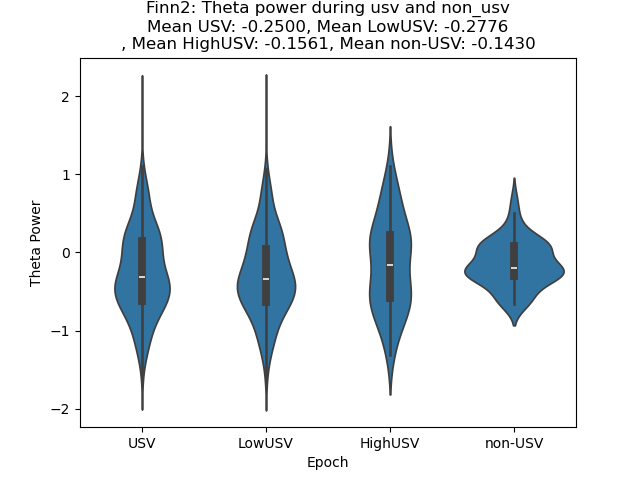

In [55]:
# Easily plot with seaborn
_, ax = plt.subplots()
title_text = f"Finn2: Theta power during usv and non_usv\nMean USV: {theta_power_usvs.mean():.4f}, Mean LowUSV: {theta_power_lowusvs.mean():.4f}\n, Mean HighUSV: {theta_power_highusvs.mean():.4f}, Mean non-USV: {theta_power_non_usvs.mean():.4f}"
ax.set_title(title_text)
sns.violinplot(data=theta_power_df, x="Epoch", y="Theta Power")

In [56]:
theta_power_non_usvs.mean()

-0.1430464570890594

## Violin plot for Low/High USV only

In [57]:
recording_duration = 3000 
theta_power_usvs = []
theta_power_non_usvs = []
theta_power_highusvs = [] 
theta_power_lowusvs = []

for i, usv_epoch in enumerate(usv_epochs):
    if usv_epoch.stops > recording_duration:

        usv_epoch.stops = recording_duration
    

    if usv_epoch.to_dataframe()['Freq_Min'].values[0] > 23:

        power_slice = theta_power_sg.time_slice(t_start=usv_epoch.starts[0], t_stop=min(usv_epoch.stops[0], recording_duration))
        theta_power_highusvs.append(power_slice.traces[0].mean())
        
    if usv_epoch.to_dataframe()['Freq_Min'].values[0] < 23:

        power_slice = theta_power_sg.time_slice(t_start=usv_epoch.starts[0], t_stop=min(usv_epoch.stops[0], recording_duration))
        theta_power_lowusvs.append(power_slice.traces[0].mean())
         
theta_power_lowusvs= np.array(theta_power_lowusvs)
theta_power_highusvs = np.array(theta_power_highusvs)
theta_power_usvs = np.array(theta_power_usvs)
theta_power_non_usvs = np.array(theta_power_non_usvs)


df1 = pd.DataFrame({"Theta Power": theta_power_usvs, "Epoch": "USV"})
df2 = pd.DataFrame({"Theta Power": theta_power_lowusvs, "Epoch": "LowUSV"})
df3 = pd.DataFrame({"Theta Power": theta_power_highusvs, "Epoch": "HighUSV"})
df4 = pd.DataFrame({"Theta Power": theta_power_non_usvs, "Epoch": "non-USV"})
theta_power_df = pd.concat([df2, df3], axis=0).reset_index(drop=True)

theta_power_df

Theta Power    Epoch
0      -1.048006   LowUSV
1      -0.981177   LowUSV
2      -0.676324   LowUSV
3      -0.333682   LowUSV
4      -0.974717   LowUSV
..           ...      ...
294    -0.716195  HighUSV
295     0.317951  HighUSV
296     0.562236  HighUSV
297     0.550436  HighUSV
298    -0.047266  HighUSV

[299 rows x 2 columns]

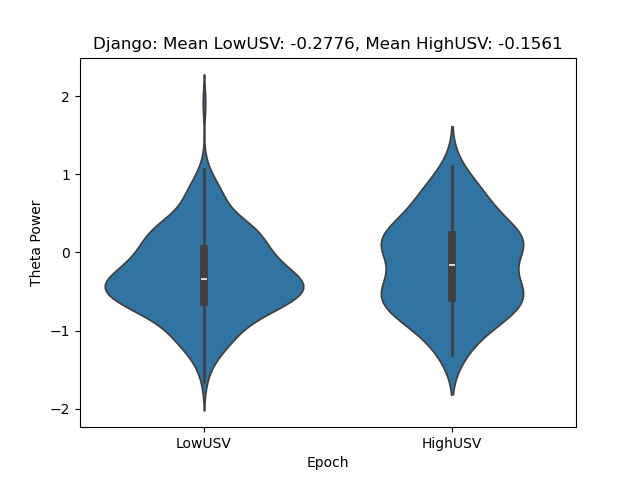

In [58]:
# Easily plot with seaborn
vio4, ax = plt.subplots()
title_text = f"{animal}: Mean LowUSV: {theta_power_lowusvs.mean():.4f}, Mean HighUSV: {theta_power_highusvs.mean():.4f}"
ax.set_title(title_text)
sns.violinplot(data=theta_power_df, x="Epoch", y="Theta Power")
vio4.savefig('/home/bowenw/Documents/thesisplots/Django usv nonusv thetapower violinplot low high ONLY.png')

## Add in DLC freezing data

In [59]:
import neuropy.io.dlcio as dlcio
dlc_path = '/data2/Trace_FC/Recording_Rats/Django/2023_03_08_training'
arena_side_pix = 60  # Keep this
arena_side_cm = 25.4  # Update this after measuring!!!
pix2cm = arena_side_cm / arena_side_pix

# Read in DLC data
sess.dlc = dlcio.DLC(dlc_path, pix2cm=pix2cm)

# Smooth position, get timestamps, and get speed
sess.dlc.get_timestamps('ms_webcam', include_str="2_training")
sess.dlc.smooth_pos(bodyparts=["crown_middle", "back_middle"])
sess.dlc.timestamps["Timestamps"] = sess.dlc.timestamps["Timestamps"].dt.tz_localize("America/Detroit")
sess.dlc.get_all_speed()

Using tracking file #1: /data2/Trace_FC/Recording_Rats/Django/2023_03_08_training/2_training/training/Django/gobears/2023_03_08/12_16_33/My_WebCam/Django_training_combined_movieDLC_resnet50_TraceFC_shockboxFeb28shuffle1_500000.h5


back_middle  crown_middle  left_ear  neck_base        nose   right_ear  \
0              NaN           NaN  2.114146   1.427178    4.192571    2.294475   
1              NaN           NaN  1.434642   2.773459    4.976536    1.240260   
2              NaN           NaN  3.174915   3.233664   53.232994  775.855143   
3              NaN           NaN  3.709458   4.849735    1.442295  772.693693   
4              NaN           NaN  4.799500   1.251170  812.393998    2.271511   
...            ...           ...       ...        ...         ...         ...   
49131          NaN           NaN  1.725541   1.319909    1.986628    0.410793   
49132          NaN           NaN  1.375519   1.198937    2.360386    2.892905   
49133          NaN           NaN  2.650305   2.220023    2.628728    0.753533   
49134          NaN           NaN  2.270356   1.481151    1.642082    0.778202   
49135          NaN           NaN       NaN        NaN         NaN         NaN   

       tail_base    tail_end  tail_middle  
0       1.467076    8.574393     6.243114  
1       1.565438    2.508958     5.558035  
2       4.144518  136.640070   124.156733  
3       2.367470  662.306779     9.446784  
4       0.407034    7.501309     2.221066  
...          ...         ...          ...  
49131   3.528101    0.912160     1.523443  
49132   0.118904    4.516608     4.587697  
49133   2.435974   26.003889     7.861756  
49134   1.450391    1.824001     4.559298  
49135        NaN         NaN          NaN  

[49136 rows x 9 columns]

In [60]:
sess.dlc.get_all_speed

<bound method DLC.get_all_speed of <neuropy.io.dlcio.DLC object at 0x7f14073a3790>>

In [61]:
# Load in openephys times to sync
import neuropy.io.openephysio as oeio
sync_df = oeio.create_sync_df(sess.basepath)
sync_df["Total seconds from start"] = (sync_df["Datetime"] - sync_df["Datetime"][0]).dt.total_seconds()

# sync DLC times to your eeg file
sess.dlc.timestamps["Total seconds from OE start"] = (sess.dlc.timestamps["Timestamps"] - sync_df["Datetime"][0]).dt.total_seconds()
sess.dlc.timestamps["eeg_time"] = np.interp(sess.dlc.timestamps["Total seconds from OE start"], sync_df["Total seconds from start"], 
                                            sync_df["eeg_time"])
sess.dlc.timestamps

start time = 2023-03-08 12:02:43-05:00
start time = 2023-03-08 12:15:15-05:00
start time = 2023-03-08 12:51:35-05:00
start time = 2023-03-08 13:45:07-05:00
start time = 2023-03-08 14:44:52-05:00
start time = 2023-03-08 17:42:37-05:00


Frame Number  Time Stamp (ms)  Buffer Index  \
0                 0              -29             0   
1                 1               20             0   
2                 2               51             0   
3                 3               99             0   
4                 4              147             0   
...             ...              ...           ...   
49131         49131          2040230             0   
49132         49132          2040278             0   
49133         49133          2040310             0   
49134         49134          2040358             0   
49135         49135          2040400             0   

                            Timestamps  Total seconds from OE start  \
0     2023-03-08 12:16:33.751000-05:00                      830.751   
1     2023-03-08 12:16:33.800000-05:00                      830.800   
2     2023-03-08 12:16:33.831000-05:00                      830.831   
3     2023-03-08 12:16:33.879000-05:00                      830.879   
4     2023-03-08 12:16:33.927000-05:00                      830.927   
...                                ...                          ...   
49131 2023-03-08 12:50:34.010000-05:00                     2871.010   
49132 2023-03-08 12:50:34.058000-05:00                     2871.058   
49133 2023-03-08 12:50:34.090000-05:00                     2871.090   
49134 2023-03-08 12:50:34.138000-05:00                     2871.138   
49135 2023-03-08 12:50:34.180000-05:00                     2871.180   

          eeg_time  
0       702.128552  
1       702.177552  
2       702.208552  
3       702.256552  
4       702.304552  
...            ...  
49131  2742.386318  
49132  2742.434318  
49133  2742.466318  
49134  2742.514318  
49135  2742.556318  

[49136 rows x 6 columns]

In [62]:
# Last calculate freezing times and plot again to check
frz_thresh = 0.25 # cm/sec  Adjust this to something that looks reasonable!
duration_thresh = 2 # sec, must be below the threshold above for at least that long to be considered freezing
bodypart_use = "crown_middle"
frz_bool = sess.dlc.speed[bodypart_use] < frz_thresh
frz_epochs = Epoch.from_boolean_array(frz_bool, t=sess.dlc.timestamps["eeg_time"])
frz_df = frz_epochs.to_dataframe()
frz_df = frz_df[frz_epochs.durations > duration_thresh]
frz_epochs = Epoch(frz_df)
frz_epochs

120 epochs
Snippet: 
         start        stop  duration label
0  846.501465  849.343463  2.841998  high
1  910.894426  914.751424  3.856998  high
2  918.926421  922.319419  3.392998  high
3  930.462414  937.919410  7.456995  high
4  941.758407  944.191406  2.432999  high

## Moving speed during highusv/lowusv/frz

In [63]:
# moving speed during frz
mean_speeds_during_freezing = []
for start, end in zip(frz_epochs.starts, frz_epochs.stops):
    epoch_speeds = sess.dlc.speed[bodypart_use][(sess.dlc.timestamps["eeg_time"] >= start) & (sess.dlc.timestamps["eeg_time"] <= end)]
    mean_speed = epoch_speeds.mean()
    mean_speeds_during_freezing.append(mean_speed)

mean_speeds_during_freezing

[0.10841589426774156,
 0.06896117774786406,
 0.09052476505546042,
 0.1049834342973061,
 0.09220196240451871,
 0.11621084123912162,
 0.0932735695201217,
 0.11007554733165531,
 0.07692834786753826,
 0.10809900299664053,
 0.10407902366790725,
 0.12377033481895669,
 0.09080519117588093,
 0.11054846734334885,
 0.11144714784644807,
 0.09803279682271265,
 0.07178856744651091,
 0.05932785033052403,
 0.114262305750668,
 0.09142619948917957,
 0.10679145492408715,
 0.07791915762609963,
 0.07351029010175966,
 0.0871558187468369,
 0.11428308252310646,
 0.05988320895401994,
 0.10482478697415,
 0.10172793032154089,
 0.11981468513285529,
 0.09839308137345923,
 0.13950910487849555,
 0.07619195169712929,
 0.07149492038204139,
 0.11116159564053986,
 0.08794507765936921,
 0.09132766898892361,
 0.08334107410643529,
 0.07165964587704263,
 0.07357314982155624,
 0.08753943599359698,
 0.08893616264905055,
 0.11064467968300923,
 0.0923411922075248,
 0.07594895555061991,
 0.062017779627778276,
 0.057751370880362

In [64]:
np.mean(mean_speeds_during_freezing)

0.09215292500215207

In [65]:
# moving speed during usv
mean_speeds_during_usv = []
for start, end in zip(usv_epochs.starts, usv_epochs.stops):
    epoch_speeds = sess.dlc.speed[bodypart_use][(sess.dlc.timestamps["eeg_time"] >= start) & (sess.dlc.timestamps["eeg_time"] <= end)]
    mean_speed = epoch_speeds.mean()
    mean_speeds_during_usv.append(mean_speed)

# Output the results
mean_speeds_during_usv

[23.35712746480872,
 21.73404241764818,
 18.173610970712318,
 5.679474845514656,
 2.3525856109292786,
 0.663287239970873,
 0.14661815133804187,
 0.2649667726380541,
 0.13756042269437616,
 0.05292984734703343,
 0.04643723952078173,
 5.871130370433913,
 0.5076406037647674,
 0.3828032957317717,
 0.029727367297464877,
 0.15947782099125563,
 0.10213104918434505,
 0.29510325110894015,
 0.5403457023077367,
 5.268917443926881,
 1.999066180896917,
 0.7683057445641035,
 0.09747020344192721,
 0.3335086224837444,
 0.1980605239112899,
 0.11258358414140321,
 0.10717999675395562,
 0.17039604692515123,
 0.8434279115101476,
 3.4858365941262512,
 5.369009819755363,
 0.43489147291896024,
 0.2938230712423248,
 0.0992170489266319,
 0.6751674563330825,
 0.6077579721750814,
 0.3191622906917442,
 1.624636854933895,
 6.436171999604593,
 1.1089416587229395,
 1.1041138461704236,
 0.13086694509863206,
 0.09379819294824791,
 0.9999973100748148,
 4.405365636622407,
 5.2126886206637755,
 0.1850506790464276,
 1.09916

In [66]:
np.mean(mean_speeds_during_usv)

1.9877132357057514

In [67]:
highusv_epochs

start         stop   Begin_Time   Freq_Min  Duration  Freq_Range  \
0    1099.471268  1099.554172   479.631519  37.931231  0.082915   25.781799   
1    1099.749291  1099.833033   479.909576  43.574457  0.083752   21.466391   
2    1100.246300  1100.312456   480.406645  41.472079  0.066164   19.585315   
3    1100.754614  1100.810833   480.915020  39.369700  0.056226   17.261634   
4    1101.555849  1101.651803   481.716352  34.722337  0.095966   20.359876   
..           ...          ...          ...        ...       ...         ...   
215  1686.915891  1687.044853  1067.146815  39.922958  0.128978   13.167528   
244  1956.043284  1956.159686  1336.306586  41.804033  0.116415   13.499483   
245  1956.367969  1956.461392  1336.631309  43.685109  0.093434   10.954498   
246  1956.585095  1956.652089  1336.848462  40.144261  0.067002   18.368149   
247  1956.884473  1956.971565  1337.147875  41.693382  0.087102   15.380558   

     Score  Accept label  
0      1.0       1        
1      1.0       1        
2      1.0       1        
3      1.0       1        
4      1.0       1        
..     ...     ...   ...  
215    1.0       1        
244    1.0       1        
245    1.0       1        
246    1.0       1        
247    1.0       1        

[68 rows x 9 columns]

In [68]:
# Moving speed during high USVs
mean_speeds_during_high_usv = []
for start, end in zip(high_usv_epochs['start'], high_usv_epochs['stop']):
    epoch_speeds = sess.dlc.speed[bodypart_use][(sess.dlc.timestamps["eeg_time"] >= start) & (sess.dlc.timestamps["eeg_time"] <= end)]
    mean_speed = epoch_speeds.mean()
    mean_speeds_during_high_usv.append(mean_speed)

# Output the results
mean_speeds_during_high_usv


[23.35712746480872,
 21.73404241764818,
 18.173610970712318,
 5.679474845514656,
 2.3525856109292786,
 0.663287239970873,
 0.14661815133804187,
 0.2649667726380541,
 0.13756042269437616,
 0.05292984734703343,
 0.04643723952078173,
 5.871130370433913,
 0.5076406037647674,
 0.3828032957317717,
 0.029727367297464877,
 0.15947782099125563,
 0.10213104918434505,
 0.29510325110894015,
 0.5403457023077367,
 5.268917443926881,
 1.999066180896917,
 0.7683057445641035,
 0.09747020344192721,
 0.3335086224837444,
 0.1980605239112899,
 0.11258358414140321,
 0.10717999675395562,
 0.17039604692515123,
 0.8434279115101476,
 3.4858365941262512,
 5.369009819755363,
 0.43489147291896024,
 0.2938230712423248,
 0.0992170489266319,
 0.6751674563330825,
 0.6077579721750814,
 0.3191622906917442,
 1.624636854933895,
 6.436171999604593,
 1.1089416587229395,
 1.1041138461704236,
 0.13086694509863206,
 0.09379819294824791,
 0.9999973100748148,
 4.405365636622407,
 5.2126886206637755,
 0.1850506790464276,
 1.09916

In [69]:
sess.filePrefix

PosixPath('/data3/Trace_FC/Recording_Rats/Django/2023_03_08_training/Django_training_denoised')

In [70]:
save_name = sess.filePrefix.with_suffix(".mean_speed_high_usv.npy")
np.save(save_name, np.array(mean_speeds_during_high_usv))

In [71]:
np.load(save_name)

array([2.33571275e+01, 2.17340424e+01, 1.81736110e+01, 5.67947485e+00,
       2.35258561e+00, 6.63287240e-01, 1.46618151e-01, 2.64966773e-01,
       1.37560423e-01, 5.29298473e-02, 4.64372395e-02, 5.87113037e+00,
       5.07640604e-01, 3.82803296e-01, 2.97273673e-02, 1.59477821e-01,
       1.02131049e-01, 2.95103251e-01, 5.40345702e-01, 5.26891744e+00,
       1.99906618e+00, 7.68305745e-01, 9.74702034e-02, 3.33508622e-01,
       1.98060524e-01, 1.12583584e-01, 1.07179997e-01, 1.70396047e-01,
       8.43427912e-01, 3.48583659e+00, 5.36900982e+00, 4.34891473e-01,
       2.93823071e-01, 9.92170489e-02, 6.75167456e-01, 6.07757972e-01,
       3.19162291e-01, 1.62463685e+00, 6.43617200e+00, 1.10894166e+00,
       1.10411385e+00, 1.30866945e-01, 9.37981929e-02, 9.99997310e-01,
       4.40536564e+00, 5.21268862e+00, 1.85050679e-01, 1.09916210e+00,
       3.74150533e+00, 1.32062512e-01, 1.25965118e-01, 9.04011706e-02,
       1.58975864e-01, 8.76669656e-01, 1.86900505e-01, 2.89192010e-02,
      

In [72]:
np.mean(mean_speeds_during_high_usv)

3.8482731640082233

In [73]:
# Moving speed during low USVs
mean_speeds_during_low_usv = []
for start, end in zip(low_usv_epochs['start'], low_usv_epochs['stop']):
    epoch_speeds = sess.dlc.speed[bodypart_use][(sess.dlc.timestamps["eeg_time"] >= start) & (sess.dlc.timestamps["eeg_time"] <= end)]
    mean_speed = epoch_speeds.mean()
    mean_speeds_during_low_usv.append(mean_speed)

# Output the results
mean_speeds_during_low_usv


[6.52792885860298,
 0.808583628609641,
 1.0370463462400972,
 1.6356846800583962,
 3.525033183321673,
 1.1260882101236813,
 1.3646060224008705,
 4.34352145262923,
 5.96405743869617,
 5.6349726720919975,
 2.2824288482671182,
 4.189299515771344,
 2.602399989231431,
 4.420976115080748,
 0.3728631462003125,
 0.2103884647455544,
 0.13999728202528378,
 0.2920062667884606,
 0.288897410186425,
 0.16056226776641638,
 0.1317694829693677,
 0.1151025275822658,
 0.15929193689461985,
 0.11591322698883058,
 0.16390462311357196,
 0.10290186296259791,
 0.14283909276401469,
 0.1854528370356983,
 0.09210127231076567,
 0.3696466367475924,
 3.684971068236023,
 0.7840199741450938,
 0.49847594555041486,
 0.1888730848488368,
 0.18174307903496134,
 0.13638779396074996,
 0.14609322281244094,
 0.06533253705540623,
 0.11771375595065194,
 0.0853218857908185,
 0.046360663139640775,
 2.1334743301566657,
 0.43301769294083703,
 0.09736975783700286,
 1.4321184038756714,
 0.14526064704815153,
 0.13901534897139975,
 0.112

In [74]:
np.mean(mean_speeds_during_low_usv)

1.440015940794201

## Violin plot for theta power during USV/nonUSV/frz

In [75]:
theta_power_frz = []
theta_power_sg = core.signal.Signal(theta_power, signal.sampling_rate)
for frz_epoch in frz_epochs:

    power_slice = theta_power_sg.time_slice(t_start=frz_epoch.starts, t_stop=frz_epoch.stops)
    theta_power_frz.append(power_slice.traces[0].mean())

theta_power_frz = np.array(theta_power_frz)

frz_df = pd.DataFrame({"Theta Power": theta_power_frz, "Epoch": "Freezing"})
theta_power_df = pd.concat((df1, df2, df3, df4, frz_df), axis=0).reset_index()

In [76]:
theta_power_frz

array([ 0.10374728, -0.1441329 , -0.39527115,  0.24626492,  0.42192388,
        0.1954902 , -0.01617879,  0.09224788, -0.25031178, -0.267002  ,
       -0.23970812, -0.22998255,  0.65601365, -0.17723062, -0.18137492,
        0.69148601,  0.04484281, -0.11847618, -0.1380535 , -0.17640066,
       -0.44535152, -0.02417762, -0.22145971, -0.29555848, -0.43142165,
       -0.17126861, -0.06184563, -0.11063726,  0.34120991, -0.08241125,
        0.27338818,  0.08285754, -0.286136  , -0.39269198,  0.27039165,
        0.24306733, -0.23641294, -0.42500396, -0.58943417, -0.56082809,
       -0.45480828, -0.36313345, -0.29345164, -0.41513373, -0.4423043 ,
       -0.46127382, -0.23093229, -0.3527011 , -0.31197214, -0.56281367,
       -0.36569065, -0.65139478, -0.37257336,  0.07806972,  0.20625702,
        0.17492623,  0.1598135 , -0.09006841, -0.08713965, -0.41499858,
        0.14854542,  0.18956634, -0.10969214,  0.03198002, -0.09769581,
        0.27870784, -0.15139556, -0.2388095 ,  0.22541303,  0.03

/tmp/ipykernel_284205/472475306.py:4: RuntimeWarning: Mean of empty slice.
  title_text = f"Django2: Theta power during usv and non_usv\nMean USV: {theta_power_usvs.mean():.4f}, Mean LowUSV: {theta_power_lowusvs.mean():.4f}\n, Mean HighUSV: {theta_power_highusvs.mean():.4f}, Mean non-USV: {theta_power_non_usvs.mean():.4f}, Mean Freezing: {theta_power_frz.mean():.4f}"
/home/bowenw/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


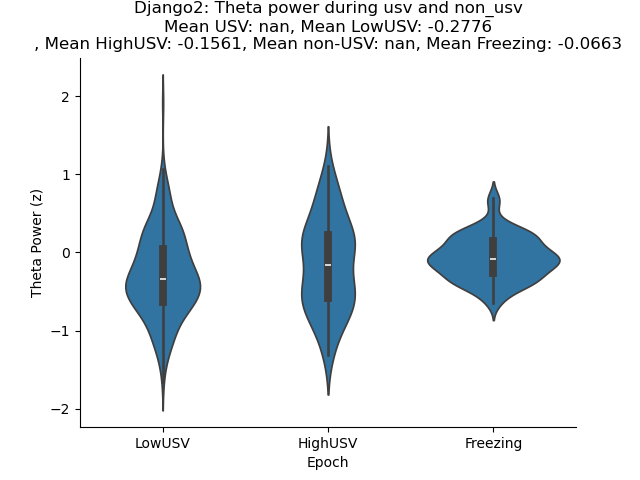

In [77]:
# Easily plot with seaborn
vio1, ax = plt.subplots()

title_text = f"Django2: Theta power during usv and non_usv\nMean USV: {theta_power_usvs.mean():.4f}, Mean LowUSV: {theta_power_lowusvs.mean():.4f}\n, Mean HighUSV: {theta_power_highusvs.mean():.4f}, Mean non-USV: {theta_power_non_usvs.mean():.4f}, Mean Freezing: {theta_power_frz.mean():.4f}"
ax.set_title(title_text)
sns.violinplot(data=theta_power_df, x="Epoch", y="Theta Power")
ax.set_ylabel("Theta Power (z)")
sns.despine(ax=ax)

In [78]:
vio1.savefig('/home/bowenw/Documents/thesisplots/Django usv nonusv thetapower violinplot low high.png')

In [79]:
import pingouin as pg
pg.pairwise_tests(data=theta_power_df, dv="Theta Power", between="Epoch", padjust="bonf")

Contrast         A        B  Paired  Parametric         T         dof  \
0    Epoch  Freezing  HighUSV   False        True  1.192046   84.638502   
1    Epoch  Freezing   LowUSV   False        True  4.826415  348.992376   
2    Epoch   HighUSV   LowUSV   False        True  1.531819  103.149899   

  alternative     p-unc    p-corr p-adjust      BF10    hedges  
0   two-sided  0.236575  0.709725     bonf     0.317  0.215055  
1   two-sided  0.000002  0.000006     bonf  6543.585  0.450028  
2   two-sided  0.128629  0.385886     bonf     0.451  0.219893

## Theta power during USV/frz/USV during frz/USV during nonfrz

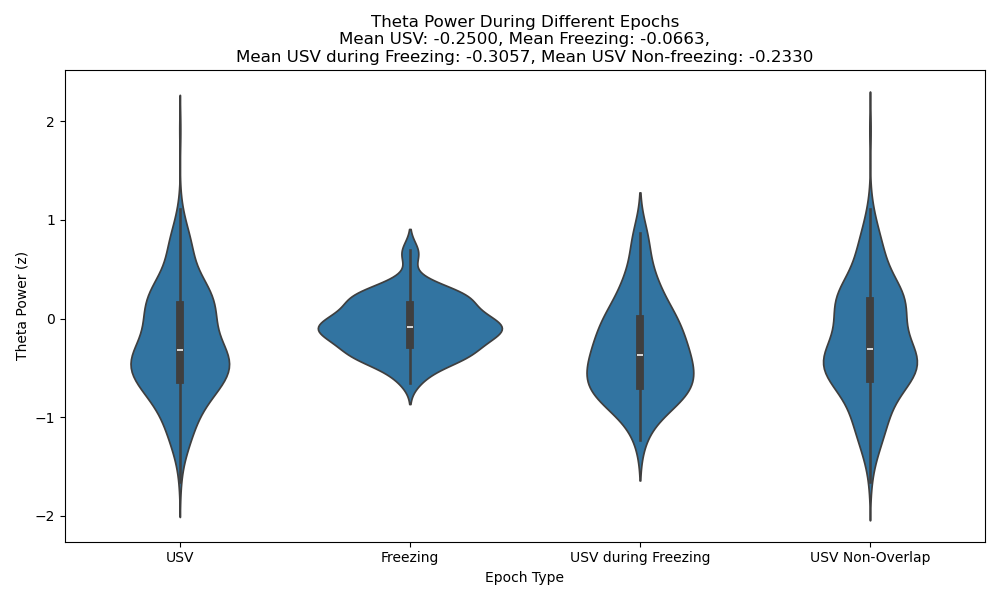

In [80]:
def categorize_usvs(usv_df, frz_df):
    usvs_during_freezing = []
    usvs_non_overlap = []
    for index, usv in usv_df.iterrows():
        overlap = False
        for _, frz in frz_df.iterrows():
            if (usv['start'] < frz['stop']) and (usv['stop'] > frz['start']):
                overlap = True
                usvs_during_freezing.append(usv)
                break
        if not overlap:
            usvs_non_overlap.append(usv)
    return pd.DataFrame(usvs_during_freezing), pd.DataFrame(usvs_non_overlap)

# Calculate the mean theta power for a given epoch type
def calculate_theta_power(signal, epochs_df):
    theta_power_values = []
    for _, epoch in epochs_df.iterrows():
        power_slice = signal.time_slice(t_start=epoch['start'], t_stop=epoch['stop'])
        theta_power_values.append(power_slice.traces[0].mean())
    return np.array(theta_power_values)

# Convert Epoch objects to DataFrames
usv_df = usv_epochs.to_dataframe()
frz_df = frz_epochs.to_dataframe()

# Categorize USVs
usv_during_freezing_df, usv_non_overlap_df = categorize_usvs(usv_df, frz_df)

# Assuming theta_power_sg is already correctly instantiated:
# Calculate theta power for each epoch type
theta_power_usv = calculate_theta_power(theta_power_sg, usv_df)
theta_power_frz = calculate_theta_power(theta_power_sg, frz_df)
theta_power_usv_during_freezing = calculate_theta_power(theta_power_sg, usv_during_freezing_df)
theta_power_usv_non_overlap = calculate_theta_power(theta_power_sg, usv_non_overlap_df)

# Create DataFrame for plotting
df_usv = pd.DataFrame({"Theta Power": theta_power_usv, "Epoch": "USV"})
df_frz = pd.DataFrame({"Theta Power": theta_power_frz, "Epoch": "Freezing"})
df_usv_during_freezing = pd.DataFrame({"Theta Power": theta_power_usv_during_freezing, "Epoch": "USV during Freezing"})
df_usv_non_overlap = pd.DataFrame({"Theta Power": theta_power_usv_non_overlap, "Epoch": "USV Non-Overlap"})

theta_power_df = pd.concat([df_usv, df_frz, df_usv_during_freezing, df_usv_non_overlap]).reset_index(drop=True)

mean_theta_power_usv = theta_power_usv.mean()
mean_theta_power_frz = theta_power_frz.mean()
mean_theta_power_usv_during_freezing = theta_power_usv_during_freezing.mean()
mean_theta_power_usv_non_freezing = theta_power_usv_non_overlap.mean()



title_text = (
    f"Theta Power During Different Epochs\n"
    f"Mean USV: {mean_theta_power_usv:.4f}, "
    f"Mean Freezing: {mean_theta_power_frz:.4f},\n"
    f"Mean USV during Freezing: {mean_theta_power_usv_during_freezing:.4f}, "
    f"Mean USV Non-freezing: {mean_theta_power_usv_non_freezing:.4f}"
)

# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.violinplot(data=theta_power_df, x="Epoch", y="Theta Power")
plt.title(title_text)
plt.xlabel("Epoch Type")
plt.ylabel("Theta Power (z)")
plt.tight_layout()
plt.show()

In [81]:
# from neuropy.analyses.oscillations import detect_theta_epochs

# def detect_theta(sess, art_epochs, theta_channel=59, mindur=1, maxdur=20, thresh=(1, None), sigma=0.125, edge_cutoff=0.25):
#     signal = sess.eegfile.get_signal()
    
#     if theta_channel is not None:
#         signal_use = signal.time_slice(channel_id=theta_channel)
#         theta_epochs, theta_power = detect_theta_epochs(signal_use, probegroup=None, mindur=mindur, maxdur=maxdur, thresh=thresh, 
#                                                         edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)
#     else:
#         theta_epochs, theta_power = detect_theta_epochs(signal, prbgrp, mindur=mindur, maxdur=maxdur, thresh=thresh, 
#                                                         edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)
    
#     sess.recinfo.write_epochs(theta_epochs, ext='tha')
#     theta_epochs_file = sess.filePrefix.with_suffix(".theta_epochs.npy")
#     theta_epochs.save(theta_epochs_file)
#     return theta_epochs, theta_power

# theta_epochs, theta_power = detect_theta(sess, art_epochs)

# SWR power

In [82]:
from neuropy.analyses.oscillations import detect_ripple_epochs
ripple_channel = 59
thresh = (2, None)  # conservative but good
edge_cutoff = 0.5
exclude_theta_epochs = False  # make this true if you end up with a lot of false positive ripples as gamma events during theta

if not exclude_theta_epochs:
    ripple_epochs, ripple_power = detect_ripple_epochs(signal, prbgrp, thresh=thresh, ripple_channel=ripple_channel, 
                                         edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)
else:
    ripple_epochs, ripple_power = detect_ripple_epochs(signal, prbgrp, thresh=thresh, ripple_channel=ripple_channel, 
                                         edge_cutoff=edge_cutoff,
                                         ignore_epochs=art_epochs.__add__(theta_epochs), return_power=True)
sess.recinfo.write_epochs(ripple_epochs, ext='swr')
ripple_epochs_file = sess.filePrefix.with_suffix(".ripple_epochs.npy")
ripple_epochs.save(ripple_epochs_file)

Selected channels for ripples: [59]
21252 epochs remaining with durations within (0.05,0.45)
/data3/Trace_FC/Recording_Rats/Django/2023_03_08_training/Django_training_denoised.ripple_epochs.npy saved


In [83]:
ripple_power_sg = core.signal.Signal(ripple_power, signal.sampling_rate)

In [84]:
recording_duration = 3000 
ripple_power_usvs = []
ripple_power_non_usvs = []

for i, usv_epoch in enumerate(usv_epochs):
    if usv_epoch.stops > recording_duration:
        usv_epoch.stops = recording_duration
    
    power_slice = ripple_power_sg.time_slice(t_start=usv_epoch.starts, t_stop=min(usv_epoch.stops, recording_duration))
    ripple_power_usvs.append(power_slice.traces[0].mean())

    next_start = usv_epochs[i+1].starts if i+1 < len(usv_epochs) else recording_duration

    if usv_epoch.stops < next_start and (next_start - usv_epoch.stops) > 1:
        power_slice = ripple_power_sg.time_slice(t_start=usv_epoch.stops, t_stop=next_start)
        ripple_power_non_usvs.append(power_slice.traces[0].mean())


ripple_power_usvs = np.array(ripple_power_usvs)
ripple_power_non_usvs = [x for x in ripple_power_non_usvs if not np.isnan(x)]
ripple_power_non_usvs = np.array(ripple_power_non_usvs)


df1 = pd.DataFrame({"ripple Power": ripple_power_usvs, "Epoch": "USV"})
df2 = pd.DataFrame({"ripple Power": ripple_power_non_usvs, "Epoch": "non-USV"})
ripple_power_df = pd.concat([df1, df2], axis=0).reset_index(drop=True)

ripple_power_df

ripple Power    Epoch
0       -0.335877      USV
1       -0.301538      USV
2       -0.004318      USV
3       -0.559110      USV
4       -1.039276      USV
..            ...      ...
346      0.169184  non-USV
347      0.386170  non-USV
348      0.698714  non-USV
349      0.311562  non-USV
350      0.446239  non-USV

[351 rows x 2 columns]

<Axes: title={'center': 'Jyn: ripple power during usv and non_usv\nMean USV: 0.4357, Mean non-USV: 0.2023'}, xlabel='Epoch', ylabel='ripple Power'>

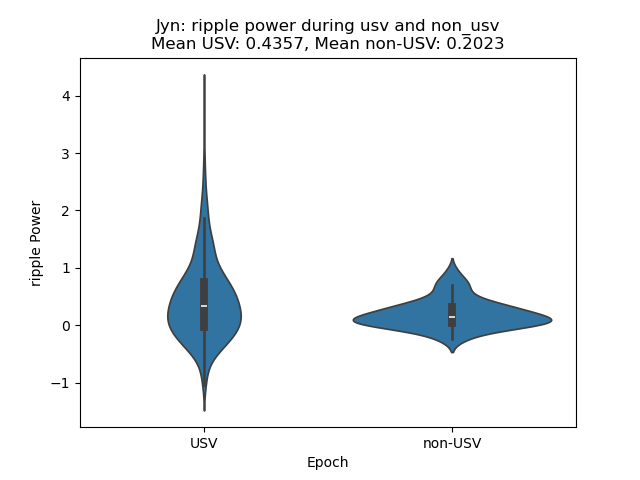

In [85]:
# Easily plot with seaborn
_, ax = plt.subplots()
title_text = f"Jyn: ripple power during usv and non_usv\nMean USV: {ripple_power_usvs.mean():.4f}, Mean non-USV: {ripple_power_non_usvs.mean():.4f}"
ax.set_title(title_text)
sns.violinplot(data=ripple_power_df, x="Epoch", y="ripple Power")

In [86]:
ripple_power_frz = []
ripple_power_sg = core.signal.Signal(ripple_power, signal.sampling_rate)
for frz_epoch in frz_epochs:

    power_slice = ripple_power_sg.time_slice(t_start=frz_epoch.starts, t_stop=frz_epoch.stops)
    ripple_power_frz.append(power_slice.traces[0].mean())

ripple_power_frz = np.array(ripple_power_frz)

frz_df = pd.DataFrame({"ripple Power": ripple_power_frz, "Epoch": "Freezing"})
ripple_power_df = pd.concat((df1, df2, frz_df), axis=0).reset_index()

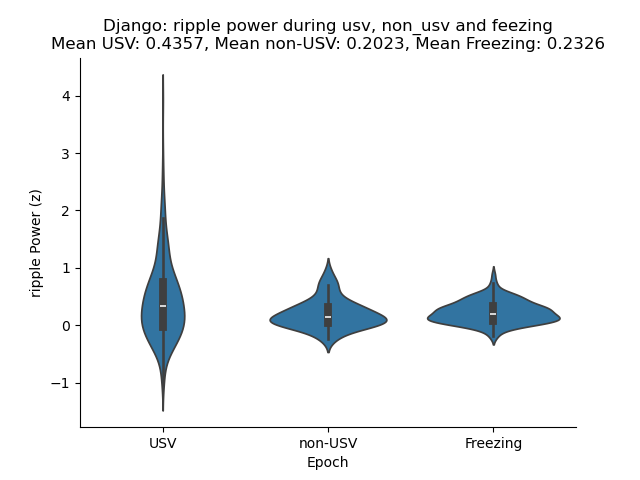

In [87]:
# Easily plot with seaborn
vio1, ax = plt.subplots()

title_text = f"Django: ripple power during usv, non_usv and feezing\nMean USV: {ripple_power_usvs.mean():.4f}, Mean non-USV: {ripple_power_non_usvs.mean():.4f}, Mean Freezing: {ripple_power_frz.mean():.4f}"
ax.set_title(title_text)
sns.violinplot(data=ripple_power_df, x="Epoch", y="ripple Power")
ax.set_ylabel("ripple Power (z)")
sns.despine(ax=ax)
vio1.savefig('/home/bowenw/Documents/thesisplots/Django usv nonusv ripplepower violinplot.png')

In [88]:
import pingouin as pg
pg.pairwise_tests(data=ripple_power_df, dv="ripple Power", between="Epoch", padjust="bonf")

Contrast         A        B  Paired  Parametric         T         dof  \
0    Epoch  Freezing      USV   False        True -4.620621  387.648603   
1    Epoch  Freezing  non-USV   False        True  0.772775   77.907957   
2    Epoch       USV  non-USV   False        True  4.371268  211.033296   

  alternative     p-unc    p-corr p-adjust      BF10    hedges  
0   two-sided  0.000005  0.000016     bonf  2782.145 -0.339318  
1   two-sided  0.441994  1.000000     bonf     0.235  0.141889  
2   two-sided  0.000019  0.000058     bonf  1042.932  0.358108

In [89]:
# def categorize_usvs(usv_df, frz_df):
#     usvs_during_freezing = []
#     usvs_non_overlap = []
#     for index, usv in usv_df.iterrows():
#         overlap = False
#         for _, frz in frz_df.iterrows():
#             if (usv['start'] < frz['stop']) and (usv['stop'] > frz['start']):
#                 overlap = True
#                 usvs_during_freezing.append(usv)
#                 break
#         if not overlap:
#             usvs_non_overlap.append(usv)
#     return pd.DataFrame(usvs_during_freezing), pd.DataFrame(usvs_non_overlap)

# # Calculate the mean ripple power for a given epoch type
# def calculate_ripple_power(signal, epochs_df):
#     ripple_power_values = []
#     for _, epoch in epochs_df.iterrows():
#         power_slice = signal.time_slice(t_start=epoch['start'], t_stop=epoch['stop'])
#         ripple_power_values.append(power_slice.traces[0].mean())
#     return np.array(ripple_power_values)

# # Convert Epoch objects to DataFrames
# usv_df = usv_epochs.to_dataframe()
# frz_df = frz_epochs.to_dataframe()

# # Categorize USVs
# usv_during_freezing_df, usv_non_overlap_df = categorize_usvs(usv_df, frz_df)

# # Assuming ripple_power_sg is already correctly instantiated:
# # Calculate ripple power for each epoch type
# ripple_power_usv = calculate_ripple_power(ripple_power_sg, usv_df)
# ripple_power_frz = calculate_ripple_power(ripple_power_sg, frz_df)
# ripple_power_usv_during_freezing = calculate_ripple_power(ripple_power_sg, usv_during_freezing_df)
# ripple_power_usv_non_overlap = calculate_ripple_power(ripple_power_sg, usv_non_overlap_df)

# # Create DataFrame for plotting
# df_usv = pd.DataFrame({"ripple Power": ripple_power_usv, "Epoch": "USV"})
# df_frz = pd.DataFrame({"ripple Power": ripple_power_frz, "Epoch": "Freezing"})
# df_usv_during_freezing = pd.DataFrame({"ripple Power": ripple_power_usv_during_freezing, "Epoch": "USV during Freezing"})
# df_usv_non_overlap = pd.DataFrame({"ripple Power": ripple_power_usv_non_overlap, "Epoch": "USV Non-Overlap"})

# ripple_power_df = pd.concat([df_usv, df_frz, df_usv_during_freezing, df_usv_non_overlap]).reset_index(drop=True)

# mean_ripple_power_usv = ripple_power_usv.mean()
# mean_ripple_power_frz = ripple_power_frz.mean()
# mean_ripple_power_usv_during_freezing = ripple_power_usv_during_freezing.mean()
# mean_ripple_power_usv_non_freezing = ripple_power_usv_non_overlap.mean()



# title_text = (
#     f"ripple Power During Different Epochs\n"
#     f"Mean USV: {mean_ripple_power_usv:.4f}, "
#     f"Mean Freezing: {mean_ripple_power_frz:.4f},\n"
#     f"Mean USV during Freezing: {mean_ripple_power_usv_during_freezing:.4f}, "
#     f"Mean USV Non-freezing: {mean_ripple_power_usv_non_freezing:.4f}"
# )

# # Plot using seaborn
# plt.figure(figsize=(10, 6))
# sns.violinplot(data=ripple_power_df, x="Epoch", y="ripple Power")
# plt.title(title_text)
# plt.xlabel("Epoch Type")
# plt.ylabel("ripple Power (z)")
# plt.tight_layout()
# plt.show()

In [90]:
ripple_power_usvs

array([-3.35877328e-01, -3.01538139e-01, -4.31785071e-03, -5.59109566e-01,
       -1.03927604e+00, -4.88708425e-02, -4.15934552e-01, -6.81999970e-04,
       -3.97633034e-01,  3.22293528e-02,  4.27883650e-01, -3.24463350e-01,
       -1.44705364e-01, -2.79347817e-01,  7.84418172e-01,  1.85857774e-01,
       -3.09535663e-01,  1.48453266e+00,  1.85099804e+00,  1.20092216e+00,
       -4.58146571e-01, -5.22488121e-01, -7.83769910e-01, -8.59970200e-01,
       -1.06918516e-01,  2.16540578e+00, -5.39546249e-02,  9.84563320e-01,
        2.24941516e-01, -9.72003995e-01, -5.65811208e-01,  3.78518707e-01,
       -2.66522985e-01, -4.26060044e-01,  2.25926763e-01,  7.11931226e-01,
       -4.91145552e-01,  1.20437408e-01, -3.08230887e-01, -3.19364443e-01,
       -5.14542842e-01,  2.08708560e-02,  5.97630396e-02, -2.88311249e-01,
        5.88910458e-01, -3.10381079e-01, -1.35255739e-01, -8.79636212e-01,
       -2.52667847e-01, -7.96062829e-01,  5.20761544e-01,  2.15842934e-02,
       -5.27406030e-01,  

In [91]:
ripple_power_non_usvs

array([ 2.65649546e-01,  7.82050994e-01,  2.45313114e-02,  9.38364575e-01,
        1.87254397e-01,  2.07760661e-01,  1.80938991e-01,  7.62438860e-01,
       -6.53225184e-02,  6.62805686e-02, -9.88269753e-02,  1.77390723e-01,
        7.04356445e-02,  4.96994411e-02,  2.69440858e-02,  3.12127768e-01,
       -1.54184528e-01, -2.09020658e-02, -2.06000180e-01, -1.77332095e-02,
        5.25787579e-02,  5.18845274e-04,  1.47667826e-02,  8.02403002e-02,
        8.78519118e-02,  3.87302385e-01, -2.37524140e-01,  1.01312449e-01,
        1.18339505e-01,  5.18973510e-02,  2.30506591e-01,  2.50745952e-01,
        7.39688562e-02,  1.20521486e-01,  5.73733590e-01,  2.26978177e-01,
        1.28515775e-01,  2.99694534e-01, -1.52044881e-02,  2.66408649e-02,
        4.16873575e-02,  6.32542602e-01,  3.61114997e-01,  3.42328536e-01,
        1.92936892e-01,  5.07220542e-01,  3.67214495e-01,  1.69183639e-01,
        3.86169786e-01,  6.98714354e-01,  3.11562489e-01,  4.46238686e-01])

In [92]:
ripple_power_frz

array([ 0.45640649,  0.01237711,  0.32960306,  0.15052912,  0.25072516,
        0.14683524,  0.33022259,  0.2732299 ,  0.14807695,  0.55271942,
        0.26049832, -0.18623985, -0.02346908,  0.50624186,  0.13791749,
        0.25283347,  0.03561447,  0.03690819,  0.22595959, -0.01856344,
        0.04195318,  0.28095414,  0.08046858,  0.14729341, -0.01143378,
        0.06905559,  0.11888094,  0.16547235,  0.04285079,  0.20663246,
        0.30947147,  0.31008802,  0.10454467,  0.04713511,  0.12976344,
        0.06097313,  0.17754425,  0.19795899,  0.19654295, -0.08631334,
        0.338735  ,  0.26287342,  0.00690124,  0.12166508,  0.11342264,
        0.09793396, -0.01216308,  0.24796979,  0.29127985,  0.05664791,
       -0.00655149, -0.18451544,  0.06659302,  0.32405361,  0.54022576,
        0.57338835,  0.28923458,  0.47082393,  0.36295826,  0.07586561,
        0.19913367,  0.07892871, -0.00104271,  0.03788269,  0.1122265 ,
        0.07796923, -0.06339252,  0.04940361,  0.11226149,  0.07

## Ripple power during low/high USV

In [93]:
recording_duration = 3000 

ripple_power_highusvs = [] 
ripple_power_lowusvs = []

for i, usv_epoch in enumerate(usv_epochs):
    if usv_epoch.stops > recording_duration:

        usv_epoch.stops = recording_duration
    

    if usv_epoch.to_dataframe()['Freq_Min'].values[0] > 23:

        power_slice = ripple_power_sg.time_slice(t_start=usv_epoch.starts[0], t_stop=min(usv_epoch.stops[0], recording_duration))
        ripple_power_highusvs.append(power_slice.traces[0].mean())
        
    if usv_epoch.to_dataframe()['Freq_Min'].values[0] < 23:

        power_slice = ripple_power_sg.time_slice(t_start=usv_epoch.starts[0], t_stop=min(usv_epoch.stops[0], recording_duration))
        ripple_power_lowusvs.append(power_slice.traces[0].mean())
         
ripple_power_lowusvs= np.array(ripple_power_lowusvs)
ripple_power_highusvs = np.array(ripple_power_highusvs)


df2 = pd.DataFrame({"ripple Power": ripple_power_lowusvs, "Epoch": "LowUSV"})
df3 = pd.DataFrame({"ripple Power": ripple_power_highusvs, "Epoch": "HighUSV"})
ripple_power_df = pd.concat([df2, df3], axis=0).reset_index(drop=True)

ripple_power_df

ripple Power    Epoch
0        1.329298   LowUSV
1        1.173899   LowUSV
2        1.208830   LowUSV
3        2.655086   LowUSV
4        0.812447   LowUSV
..            ...      ...
294      2.547954  HighUSV
295      0.045370  HighUSV
296     -0.224539  HighUSV
297      1.530011  HighUSV
298     -0.498165  HighUSV

[299 rows x 2 columns]

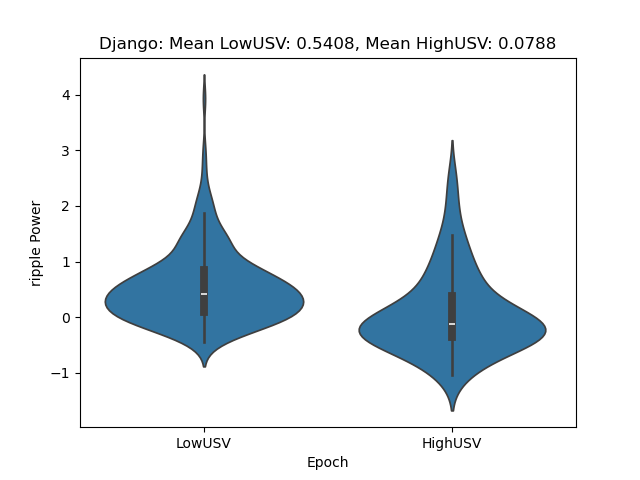

In [94]:
# Easily plot with seaborn
vio3, ax = plt.subplots()
title_text = f"{animal}: Mean LowUSV: {ripple_power_lowusvs.mean():.4f}, Mean HighUSV: {ripple_power_highusvs.mean():.4f}"
ax.set_title(title_text)
sns.violinplot(data=ripple_power_df, x="Epoch", y="ripple Power")
vio3.savefig('/home/bowenw/Documents/thesisplots/Django usv nonusv ripplepower violinplot low high ONLY.png')

## ripple power during USV/frz/USV during frz/USV during nonfrz

/tmp/ipykernel_284205/1256923151.py:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 6))


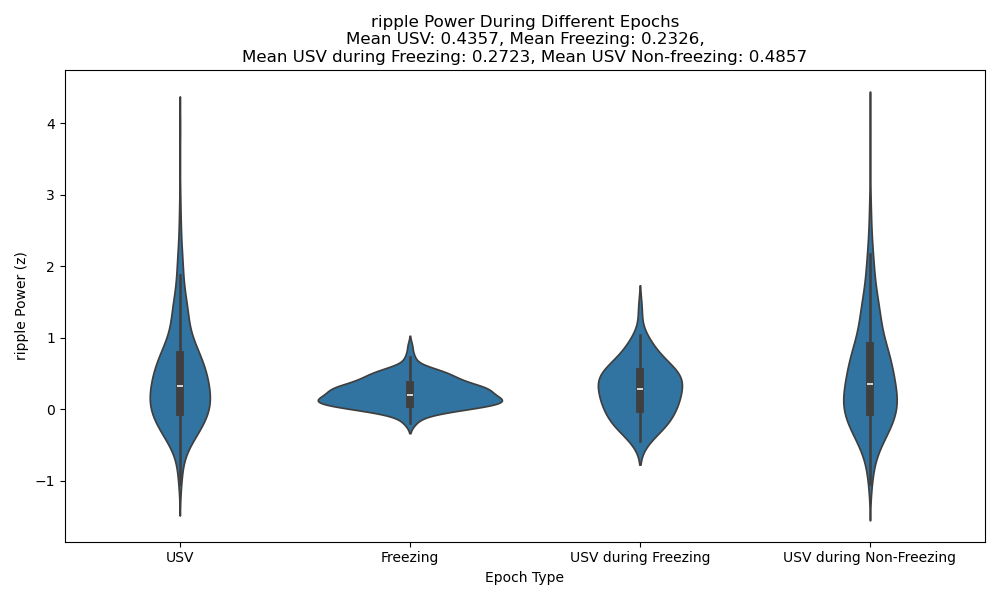

In [95]:
def categorize_usvs(usv_df, frz_df):
    usvs_during_freezing = []
    usvs_non_overlap = []
    for index, usv in usv_df.iterrows():
        overlap = False
        for _, frz in frz_df.iterrows():
            if (usv['start'] < frz['stop']) and (usv['stop'] > frz['start']):
                overlap = True
                usvs_during_freezing.append(usv)
                break
        if not overlap:
            usvs_non_overlap.append(usv)
    return pd.DataFrame(usvs_during_freezing), pd.DataFrame(usvs_non_overlap)

# Calculate the mean ripple power for a given epoch type
def calculate_ripple_power(signal, epochs_df):
    ripple_power_values = []
    for _, epoch in epochs_df.iterrows():
        power_slice = signal.time_slice(t_start=epoch['start'], t_stop=epoch['stop'])
        ripple_power_values.append(power_slice.traces[0].mean())
    return np.array(ripple_power_values)

# Convert Epoch objects to DataFrames
usv_df = usv_epochs.to_dataframe()
frz_df = frz_epochs.to_dataframe()

# Categorize USVs
usv_during_freezing_df, usv_non_overlap_df = categorize_usvs(usv_df, frz_df)

# Assuming ripple_power_sg is already correctly instantiated:
# Calculate ripple power for each epoch type
ripple_power_usv = calculate_ripple_power(ripple_power_sg, usv_df)
ripple_power_frz = calculate_ripple_power(ripple_power_sg, frz_df)
ripple_power_usv_during_freezing = calculate_ripple_power(ripple_power_sg, usv_during_freezing_df)
ripple_power_usv_non_overlap = calculate_ripple_power(ripple_power_sg, usv_non_overlap_df)

# Create DataFrame for plotting
df_usv = pd.DataFrame({"ripple Power": ripple_power_usv, "Epoch": "USV"})
df_frz = pd.DataFrame({"ripple Power": ripple_power_frz, "Epoch": "Freezing"})
df_usv_during_freezing = pd.DataFrame({"ripple Power": ripple_power_usv_during_freezing, "Epoch": "USV during Freezing"})
df_usv_non_overlap = pd.DataFrame({"ripple Power": ripple_power_usv_non_overlap, "Epoch": "USV during Non-Freezing"})

ripple_power_df = pd.concat([df_usv, df_frz, df_usv_during_freezing, df_usv_non_overlap]).reset_index(drop=True)

mean_ripple_power_usv = ripple_power_usv.mean()
mean_ripple_power_frz = ripple_power_frz.mean()
mean_ripple_power_usv_during_freezing = ripple_power_usv_during_freezing.mean()
mean_ripple_power_usv_non_freezing = ripple_power_usv_non_overlap.mean()



title_text = (
    f"ripple Power During Different Epochs\n"
    f"Mean USV: {mean_ripple_power_usv:.4f}, "
    f"Mean Freezing: {mean_ripple_power_frz:.4f},\n"
    f"Mean USV during Freezing: {mean_ripple_power_usv_during_freezing:.4f}, "
    f"Mean USV Non-freezing: {mean_ripple_power_usv_non_freezing:.4f}"
)

# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.violinplot(data=ripple_power_df, x="Epoch", y="ripple Power")
plt.title(title_text)
plt.xlabel("Epoch Type")
plt.ylabel("ripple Power (z)")
plt.tight_layout()
plt.show()

In [96]:
theta_power_frz.mean()

-0.06627569265054424

In [97]:
usv_epochs

299 epochs
Snippet: 
          start         stop  Begin_Time   Freq_Min  Duration  Freq_Range  \
0  1099.471268  1099.554172  479.631519  37.931231  0.082915   25.781799   
1  1099.749291  1099.833033  479.909576  43.574457  0.083752   21.466391   
2  1100.246300  1100.312456  480.406645  41.472079  0.066164   19.585315   
3  1100.754614  1100.810833  480.915020  39.369700  0.056226   17.261634   
4  1101.555849  1101.651803  481.716352  34.722337  0.095966   20.359876   

   Score  Accept label  
0    1.0       1        
1    1.0       1        
2    1.0       1        
3    1.0       1        
4    1.0       1        

In [98]:
lowusv_epochs

start         stop   Begin_Time   Freq_Min  Duration  Freq_Range  \
63   1385.260982  1386.517366   765.455615  16.680464  1.256535   16.179912   
64   1386.595436  1387.111989   766.790230  16.208057  0.516615    9.566225   
65   1387.175823  1387.671112   767.370687  14.672737  0.495348   10.983444   
66   1387.730032  1387.919642   767.924963  16.680464  0.189632    8.030905   
67   1387.974406  1388.446657   768.169366  16.680464  0.472308    8.857616   
..           ...          ...          ...        ...       ...         ...   
294  2235.404953  2235.847877  1615.701863  16.277778  0.442977    7.666667   
295  2235.905064  2236.316906  1616.202034  17.375613  0.411892    7.474265   
296  2236.384538  2236.808221  1616.681566  15.579628  0.423734    9.516029   
297  2236.878080  2237.401800  1617.175167  17.166667  0.523783    7.597036   
298  2237.488905  2237.812043  1617.786066  16.464840  0.323177    6.639090   

     Score  Accept label  
63     1.0       1        
64     1.0       1        
65     1.0       1        
66     1.0       1        
67     1.0       1        
..     ...     ...   ...  
294    1.0       1        
295    1.0       1        
296    1.0       1        
297    1.0       1        
298    1.0       1        

[231 rows x 9 columns]

In [99]:
theta_epochs

1511 epochs
Snippet: 
       start      stop  peak_time  peak_power label
0  320.2904  321.3664   320.6152    3.131790      
1  377.4088  378.6224   377.8792    2.076891      
2  400.1768  401.2952   400.6976    1.105415      
3  415.3056  418.3960   416.5008    1.764574      
4  465.5208  466.8808   466.6632    1.897630      

## Theta/High/Low USV epoch plot

/tmp/ipykernel_284205/1734047521.py:22: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rect = Rectangle((start_time, 0.4), duration, 0.3, color='darkblue', edgecolor='none', alpha=0.7)
/tmp/ipykernel_284205/1734047521.py:31: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rect = Rectangle((start_time, 0.4), duration, 0.3, color='lightblue', edgecolor='none', alpha=0.5)
/tmp/ipykernel_284205/1734047521.py:37: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rect = Rectangle((start_time, 0.1), duration, 0.3, color='green', edgecolor='none', alpha=0.5)


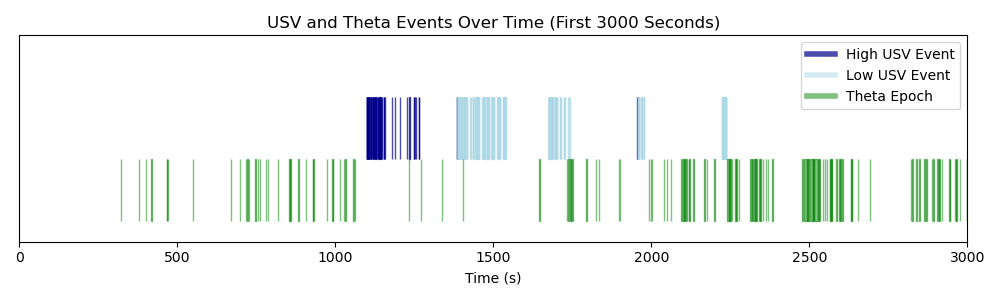

In [100]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

# Assuming theta_epochs are defined elsewhere
theta_start_times = theta_epochs.starts
theta_stop_times = theta_epochs.stops
theta_durations = theta_stop_times - theta_start_times

usv_start_times = usv_epochs.starts
usv_stop_times = usv_epochs.stops
usv_durations = usv_epochs.stops - usv_epochs.starts

fig, ax = plt.subplots(figsize=(10, 3))

# Plot high USV events in another color (now on top)
for _, row in highusv_epochs.iterrows():
    start_time = row['start']
    stop_time = row['stop']
    duration = stop_time - start_time
    if start_time <= 3000:  # Limit to the first 3000 seconds
        rect = Rectangle((start_time, 0.4), duration, 0.3, color='darkblue', edgecolor='none', alpha=0.7)
        ax.add_patch(rect)

# Plot low USV events in one color (now second from top)
for _, row in lowusv_epochs.iterrows():
    start_time = row['start']
    stop_time = row['stop']
    duration = stop_time - start_time
    if start_time <= 3000:  # Limit to the first 3000 seconds
        rect = Rectangle((start_time, 0.4), duration, 0.3, color='lightblue', edgecolor='none', alpha=0.5)
        ax.add_patch(rect)

# Plot Theta epochs (now third from top)
for start_time, duration in zip(theta_start_times, theta_durations):
    if start_time <= 3000:  # Limit to the first 3000 seconds
        rect = Rectangle((start_time, 0.1), duration, 0.3, color='green', edgecolor='none', alpha=0.5)
        ax.add_patch(rect)

# Customize the legend
custom_lines = [
    Line2D([0], [0], color='darkblue', lw=4, alpha=0.7),
    Line2D([0], [0], color='lightblue', lw=4, alpha=0.5),
    Line2D([0], [0], color='green', lw=4, alpha=0.5),
]
ax.legend(custom_lines, ['High USV Event', 'Low USV Event', 'Theta Epoch'])

# Adjust limits and labels
ax.set_xlim(0, 3000)  # Limit x-axis to the first 3000 seconds
ax.set_ylim(0, 1)  # Adjusted to accommodate all rows without overlapping
ax.set_xlabel('Time (s)')
ax.set_yticks([])
plt.title('USV and Theta Events Over Time (First 3000 Seconds)')
plt.tight_layout()
plt.show()

In [101]:
theta_epochs

1511 epochs
Snippet: 
       start      stop  peak_time  peak_power label
0  320.2904  321.3664   320.6152    3.131790      
1  377.4088  378.6224   377.8792    2.076891      
2  400.1768  401.2952   400.6976    1.105415      
3  415.3056  418.3960   416.5008    1.764574      
4  465.5208  466.8808   466.6632    1.897630      

In [102]:
highusv_epochs

start         stop   Begin_Time   Freq_Min  Duration  Freq_Range  \
0    1099.471268  1099.554172   479.631519  37.931231  0.082915   25.781799   
1    1099.749291  1099.833033   479.909576  43.574457  0.083752   21.466391   
2    1100.246300  1100.312456   480.406645  41.472079  0.066164   19.585315   
3    1100.754614  1100.810833   480.915020  39.369700  0.056226   17.261634   
4    1101.555849  1101.651803   481.716352  34.722337  0.095966   20.359876   
..           ...          ...          ...        ...       ...         ...   
215  1686.915891  1687.044853  1067.146815  39.922958  0.128978   13.167528   
244  1956.043284  1956.159686  1336.306586  41.804033  0.116415   13.499483   
245  1956.367969  1956.461392  1336.631309  43.685109  0.093434   10.954498   
246  1956.585095  1956.652089  1336.848462  40.144261  0.067002   18.368149   
247  1956.884473  1956.971565  1337.147875  41.693382  0.087102   15.380558   

     Score  Accept label  
0      1.0       1        
1      1.0       1        
2      1.0       1        
3      1.0       1        
4      1.0       1        
..     ...     ...   ...  
215    1.0       1        
244    1.0       1        
245    1.0       1        
246    1.0       1        
247    1.0       1        

[68 rows x 9 columns]

## All USV start/Theta stop CCG

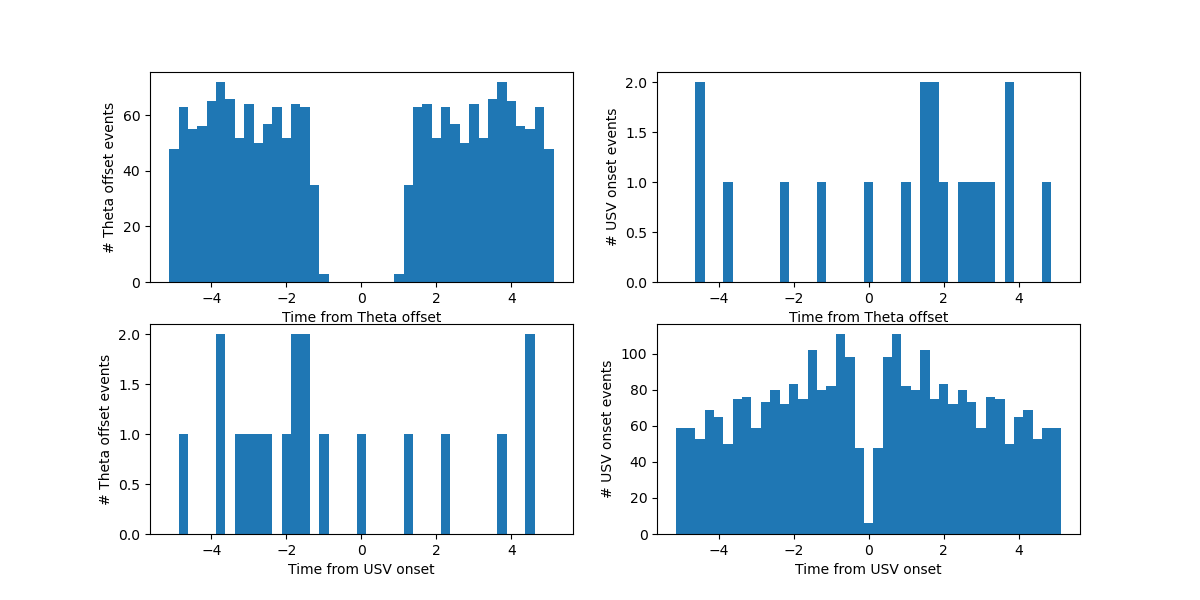

In [103]:
from neuropy.utils.ccg import correlograms

# We observe that right after theta ends there seem to be a lot of USVs starting - check this by looking at CCG between theta off and
# USV onset times
theta_off_usv_on_times = [theta_epochs.stops, usv_epochs.starts]
theta_off_usv_on_ids = np.hstack([np.ones_like(array)*ida for ida, array in enumerate(theta_off_usv_on_times)])
theta_off_usv_on_times = np.hstack(theta_off_usv_on_times)
sort_ids = np.argsort(theta_off_usv_on_times)

theta_off_usv_on_times = theta_off_usv_on_times[sort_ids]
theta_off_usv_on_ids = theta_off_usv_on_ids[sort_ids].astype(int)

window_size = 10 # seconds
bin_size = 0.25 # seconds
ccg = correlograms(theta_off_usv_on_times, theta_off_usv_on_ids, sample_rate=30, window_size=window_size, bin_size=bin_size)
# Sample plotting code
time_bins = np.linspace(-window_size/2, window_size/2, np.array(window_size/bin_size + 1, dtype=int))
_, ax = plt.subplots(2, 2, figsize=(12, 6))

var_names = ['Theta offset', 'USV onset']
for idv, (a, ccg_use) in enumerate(zip(ax, ccg)):
    for ida2, (a2, ccg_use2) in enumerate(zip(a, ccg_use)): 
        a2.bar(time_bins, ccg_use2, width=bin_size)
        a2.set_xlabel(f"Time from {var_names[idv]}")
        a2.set_ylabel(f"# {var_names[ida2]} events")
fig.savefig('/home/bowenw/Documents/thesisplots/Django usv-theta ccg all.png')

In [104]:
# from neuropy.utils.ccg import correlograms

# # We observe that right after theta ends there seem to be a lot of USVs starting - check this by looking at CCG between theta off and
# # USV onset times
# theta_off_usv_on_times = [theta_epochs.starts, usv_epochs.stops]
# theta_off_usv_on_ids = np.hstack([np.ones_like(array)*ida for ida, array in enumerate(theta_off_usv_on_times)])
# theta_off_usv_on_times = np.hstack(theta_off_usv_on_times)
# sort_ids = np.argsort(theta_off_usv_on_times)

# theta_off_usv_on_times = theta_off_usv_on_times[sort_ids]
# theta_off_usv_on_ids = theta_off_usv_on_ids[sort_ids].astype(int)

# window_size = 10 # seconds
# bin_size = 0.25 # seconds
# ccg = correlograms(theta_off_usv_on_times, theta_off_usv_on_ids, sample_rate=30, window_size=window_size, bin_size=bin_size)

In [105]:
# # Sample plotting code
# time_bins = np.linspace(-window_size/2, window_size/2, np.array(window_size/bin_size + 1, dtype=int))
# _, ax = plt.subplots(2, 2, figsize=(12, 6))

# var_names = ['Theta offset', 'USV onset']
# for idv, (a, ccg_use) in enumerate(zip(ax, ccg)):
#     for ida2, (a2, ccg_use2) in enumerate(zip(a, ccg_use)): 
#         a2.bar(time_bins, ccg_use2, width=bin_size)
#         a2.set_xlabel(f"Time from {var_names[idv]}")
#         a2.set_ylabel(f"# {var_names[ida2]} events")

## Low USV start/Theta stopCCG

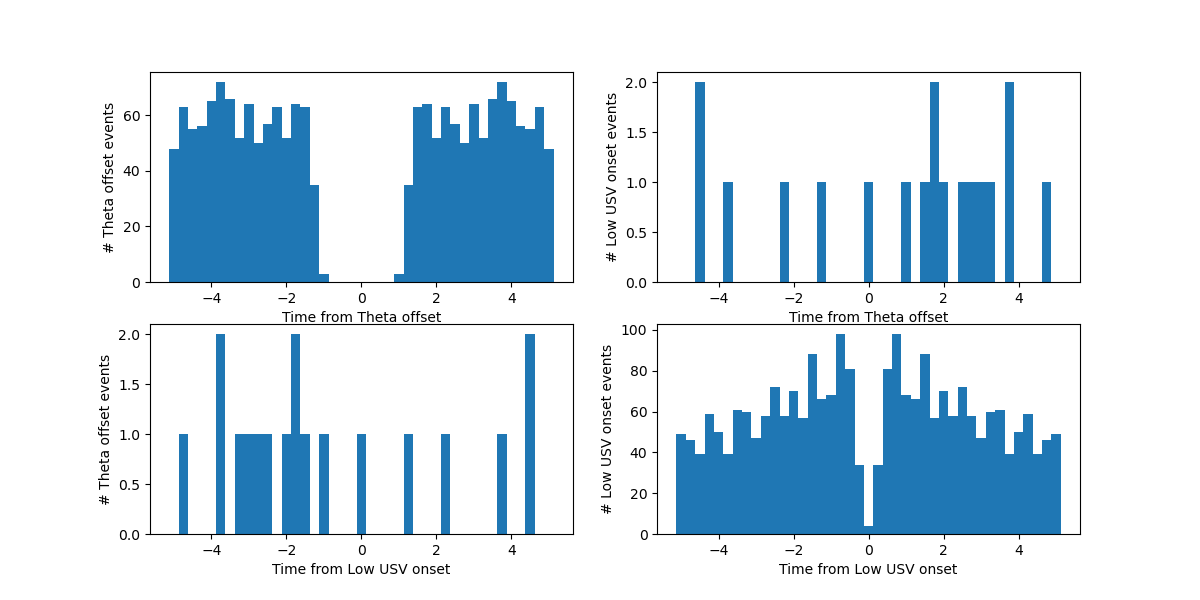

In [106]:
#low usv
from neuropy.utils.ccg import correlograms

# We observe that right after theta ends there seem to be a lot of USVs starting - check this by looking at CCG between theta off and
# USV onset times
theta_off_lowusv_on_times = [theta_epochs.stops, low_usv_epochs.start]
theta_off_lowusv_on_ids = np.hstack([np.ones_like(array)*ida for ida, array in enumerate(theta_off_lowusv_on_times)])
theta_off_lowusv_on_times = np.hstack(theta_off_lowusv_on_times)
sort_ids = np.argsort(theta_off_lowusv_on_times)

theta_off_lowusv_on_times = theta_off_lowusv_on_times[sort_ids]
theta_off_lowusv_on_ids = theta_off_lowusv_on_ids[sort_ids].astype(int)

window_size = 10 # seconds
bin_size = 0.25 # seconds
ccg = correlograms(theta_off_lowusv_on_times, theta_off_lowusv_on_ids, sample_rate=30, window_size=window_size, bin_size=bin_size)
# Sample plotting code, low_usv
time_bins = np.linspace(-window_size/2, window_size/2, np.array(window_size/bin_size + 1, dtype=int))
_, ax = plt.subplots(2, 2, figsize=(12, 6))

var_names = ['Theta offset', 'Low USV onset']
for idv, (a, ccg_use) in enumerate(zip(ax, ccg)):
    for ida2, (a2, ccg_use2) in enumerate(zip(a, ccg_use)): 
        a2.bar(time_bins, ccg_use2, width=bin_size)
        a2.set_xlabel(f"Time from {var_names[idv]}")
        a2.set_ylabel(f"# {var_names[ida2]} events")
fig.savefig('/home/bowenw/Documents/thesisplots/Django usv-theta ccg lowusv.png')

## Low USV start/Theta stopCCG

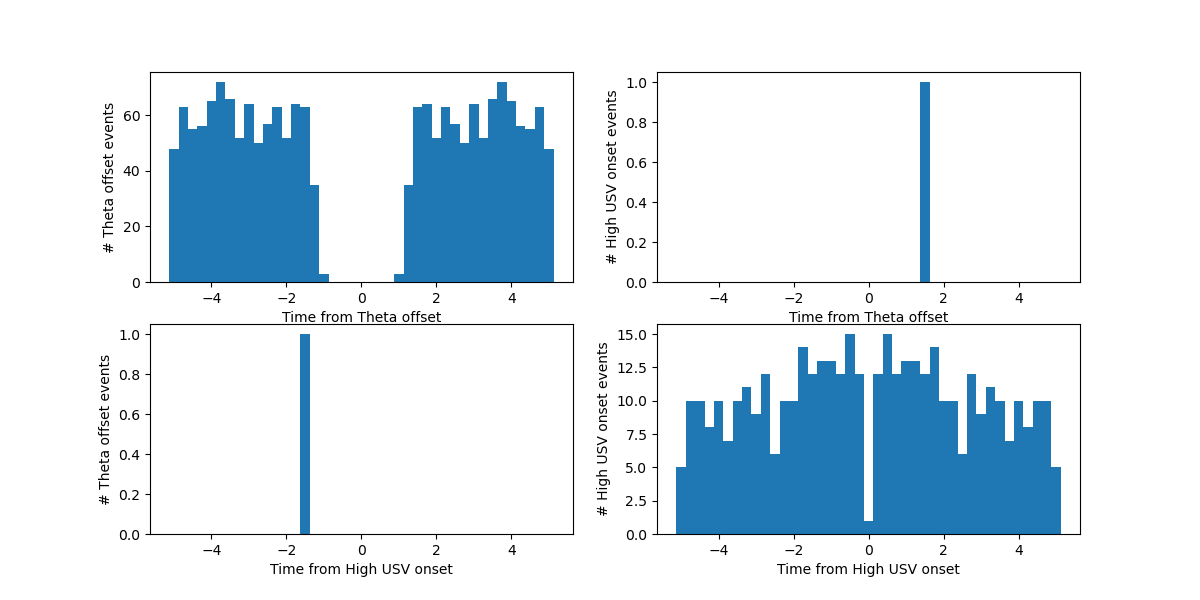

In [107]:
#high usv
from neuropy.utils.ccg import correlograms

# We observe that right after theta ends there seem to be a lot of USVs starting - check this by looking at CCG between theta off and
# USV onset times
theta_off_highusv_on_times = [theta_epochs.stops, high_usv_epochs.start]
theta_off_highusv_on_ids = np.hstack([np.ones_like(array)*ida for ida, array in enumerate(theta_off_highusv_on_times)])
theta_off_highusv_on_times = np.hstack(theta_off_highusv_on_times)
sort_ids = np.argsort(theta_off_highusv_on_times)

theta_off_highusv_on_times = theta_off_highusv_on_times[sort_ids]
theta_off_highusv_on_ids = theta_off_highusv_on_ids[sort_ids].astype(int)

window_size = 10 # seconds
bin_size = 0.25 # seconds
ccg = correlograms(theta_off_highusv_on_times, theta_off_highusv_on_ids, sample_rate=30, window_size=window_size, bin_size=bin_size)
# Sample plotting code, low_usv
time_bins = np.linspace(-window_size/2, window_size/2, np.array(window_size/bin_size + 1, dtype=int))
_, ax = plt.subplots(2, 2, figsize=(12, 6))

var_names = ['Theta offset', 'High USV onset']
for idv, (a, ccg_use) in enumerate(zip(ax, ccg)):
    for ida2, (a2, ccg_use2) in enumerate(zip(a, ccg_use)): 
        a2.bar(time_bins, ccg_use2, width=bin_size)
        a2.set_xlabel(f"Time from {var_names[idv]}")
        a2.set_ylabel(f"# {var_names[ida2]} events")
save_dir = '/home/bowenw/Documents/thesisplots/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

fig.savefig(os.path.join(save_dir, 'Django_usv-ripple_ccg_all.png'))

## All Theta CCG together

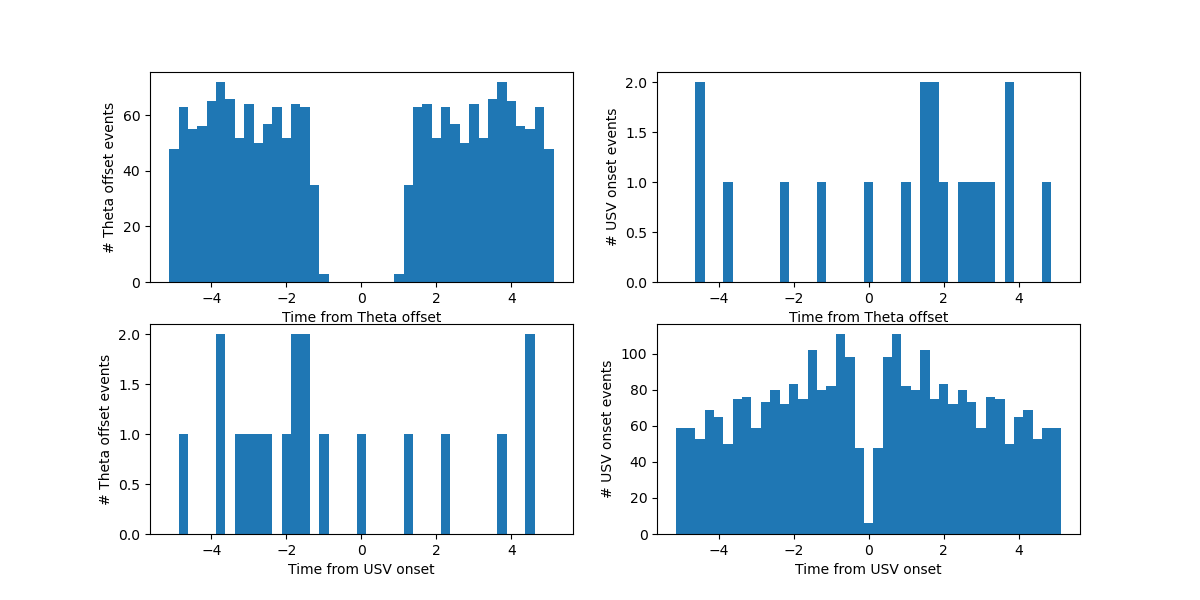

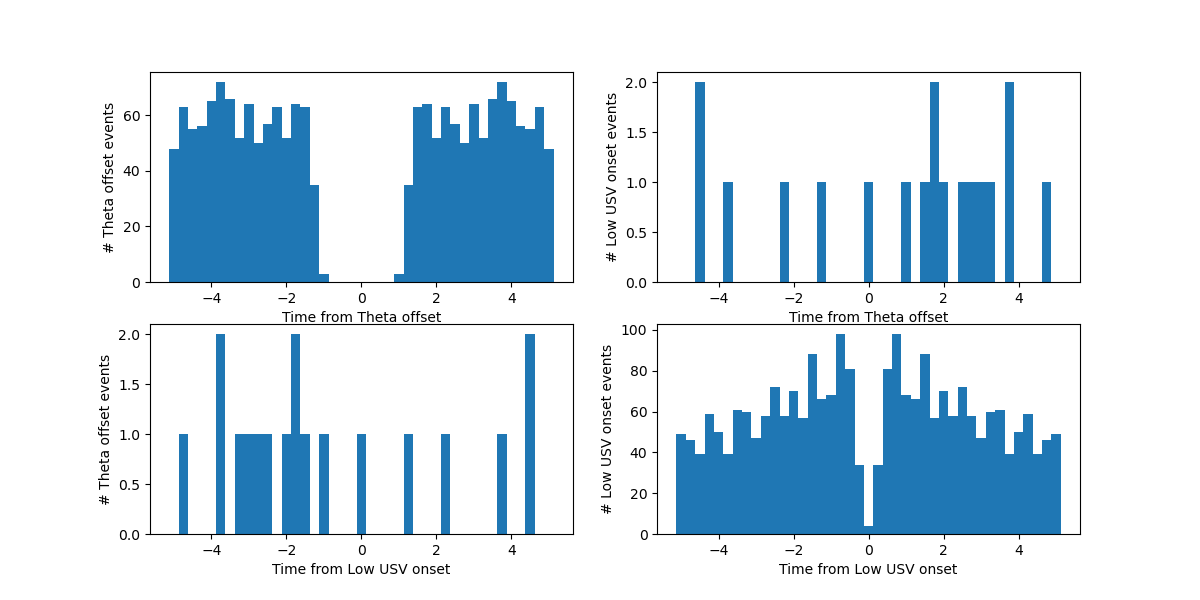

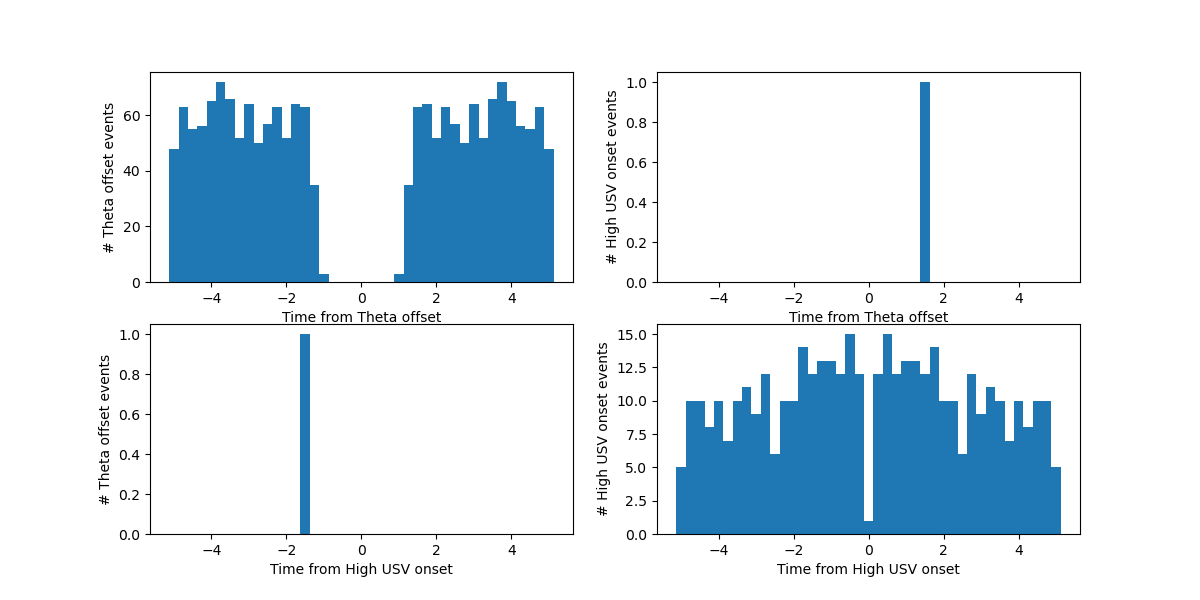

In [108]:
from neuropy.utils.ccg import correlograms

# We observe that right after theta ends there seem to be a lot of USVs starting - check this by looking at CCG between theta off and
# USV onset times
theta_off_usv_on_times = [theta_epochs.stops, usv_epochs.starts]
theta_off_usv_on_ids = np.hstack([np.ones_like(array)*ida for ida, array in enumerate(theta_off_usv_on_times)])
theta_off_usv_on_times = np.hstack(theta_off_usv_on_times)
sort_ids = np.argsort(theta_off_usv_on_times)

theta_off_usv_on_times = theta_off_usv_on_times[sort_ids]
theta_off_usv_on_ids = theta_off_usv_on_ids[sort_ids].astype(int)

window_size = 10 # seconds
bin_size = 0.25 # seconds
ccg = correlograms(theta_off_usv_on_times, theta_off_usv_on_ids, sample_rate=30, window_size=window_size, bin_size=bin_size)
# Sample plotting code
time_bins = np.linspace(-window_size/2, window_size/2, np.array(window_size/bin_size + 1, dtype=int))
corr1_fig, ax = plt.subplots(2, 2, figsize=(12, 6))

var_names = ['Theta offset', 'USV onset']
for idv, (a, ccg_use) in enumerate(zip(ax, ccg)):
    for ida2, (a2, ccg_use2) in enumerate(zip(a, ccg_use)): 
        a2.bar(time_bins, ccg_use2, width=bin_size)
        a2.set_xlabel(f"Time from {var_names[idv]}")
        a2.set_ylabel(f"# {var_names[ida2]} events")

corr1_fig.savefig('/home/bowenw/Documents/thesisplots/Django usv-theta ccg all.png')

#low usv
from neuropy.utils.ccg import correlograms

# We observe that right after theta ends there seem to be a lot of USVs starting - check this by looking at CCG between theta off and
# USV onset times
theta_off_lowusv_on_times = [theta_epochs.stops, lowusv_epochs.start]
theta_off_lowusv_on_ids = np.hstack([np.ones_like(array)*ida for ida, array in enumerate(theta_off_lowusv_on_times)])
theta_off_lowusv_on_times = np.hstack(theta_off_lowusv_on_times)
sort_ids = np.argsort(theta_off_lowusv_on_times)

theta_off_lowusv_on_times = theta_off_lowusv_on_times[sort_ids]
theta_off_lowusv_on_ids = theta_off_lowusv_on_ids[sort_ids].astype(int)

window_size = 10 # seconds
bin_size = 0.25 # seconds
ccg = correlograms(theta_off_lowusv_on_times, theta_off_lowusv_on_ids, sample_rate=30, window_size=window_size, bin_size=bin_size)
# Sample plotting code, low_usv
time_bins = np.linspace(-window_size/2, window_size/2, np.array(window_size/bin_size + 1, dtype=int))
corr2_fig, ax = plt.subplots(2, 2, figsize=(12, 6))

var_names = ['Theta offset', 'Low USV onset']
for idv, (a, ccg_use) in enumerate(zip(ax, ccg)):
    for ida2, (a2, ccg_use2) in enumerate(zip(a, ccg_use)): 
        a2.bar(time_bins, ccg_use2, width=bin_size)
        a2.set_xlabel(f"Time from {var_names[idv]}")
        a2.set_ylabel(f"# {var_names[ida2]} events")

corr2_fig.savefig('/home/bowenw/Documents/thesisplots/Django usv-theta ccg lowusv.png')

#high usv
from neuropy.utils.ccg import correlograms

# We observe that right after theta ends there seem to be a lot of USVs starting - check this by looking at CCG between theta off and
# USV onset times
theta_off_highusv_on_times = [theta_epochs.stops, highusv_epochs.start]
theta_off_highusv_on_ids = np.hstack([np.ones_like(array)*ida for ida, array in enumerate(theta_off_highusv_on_times)])
theta_off_highusv_on_times = np.hstack(theta_off_highusv_on_times)
sort_ids = np.argsort(theta_off_highusv_on_times)

theta_off_highusv_on_times = theta_off_highusv_on_times[sort_ids]
theta_off_highusv_on_ids = theta_off_highusv_on_ids[sort_ids].astype(int)

window_size = 10 # seconds
bin_size = 0.25 # seconds
ccg = correlograms(theta_off_highusv_on_times, theta_off_highusv_on_ids, sample_rate=30, window_size=window_size, bin_size=bin_size)
# Sample plotting code, low_usv
time_bins = np.linspace(-window_size/2, window_size/2, np.array(window_size/bin_size + 1, dtype=int))
corr3_fig, ax = plt.subplots(2, 2, figsize=(12, 6))


var_names = ['Theta offset', 'High USV onset']
for idv, (a, ccg_use) in enumerate(zip(ax, ccg)):
    for ida2, (a2, ccg_use2) in enumerate(zip(a, ccg_use)): 
        a2.bar(time_bins, ccg_use2, width=bin_size)
        a2.set_xlabel(f"Time from {var_names[idv]}")
        a2.set_ylabel(f"# {var_names[ida2]} events")
corr3_fig.savefig('/home/bowenw/Documents/thesisplots/Django usv-theta ccg highusv.png')

# Use DeepLabCut to get motion data

In [109]:
from neuropy.io.dlcio import DLC
dlc = DLC('/data2/Trace_FC/Recording_Rats/Django/2023_03_08_training')  # DLC data lives in a different directory for Django! Adjust for other animals!!!

Using tracking file #1: /data2/Trace_FC/Recording_Rats/Django/2023_03_08_training/2_training/training/Django/gobears/2023_03_08/12_16_33/My_WebCam/Django_training_combined_movieDLC_resnet50_TraceFC_shockboxFeb28shuffle1_500000.h5


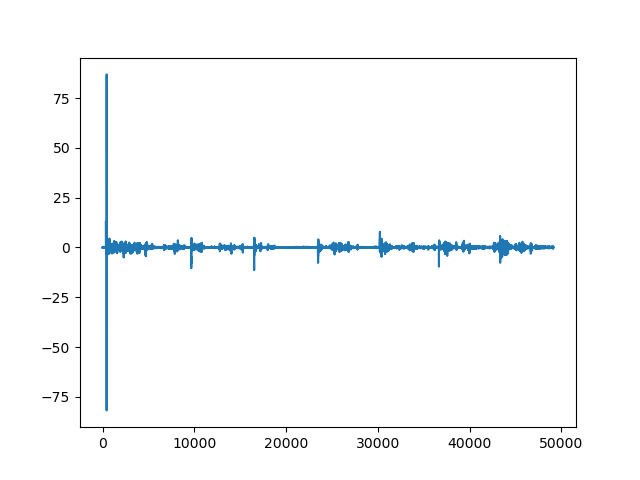

In [110]:
_, ax = plt.subplots()
ax.plot(dlc.pos_data['crown_middle'].x.diff())

In [111]:
dlc.pos_data.shape[0]/dlc.SampleRate/60

13.648888888888887

In [112]:
dlc.SampleRate

60.0

In [113]:
from neuropy.analyses.oscillations import detect_ripple_epochs
ripple_channel = 59
thresh = (2, None)  # conservative but good
edge_cutoff = 0.5
exclude_theta_epochs = False  # make this true if you end up with a lot of false positive ripples as gamma events during theta

if not exclude_theta_epochs:
    ripple_epochs = detect_ripple_epochs(signal, prbgrp, thresh=thresh, ripple_channel=ripple_channel, 
                                         edge_cutoff=edge_cutoff, ignore_epochs=art_epochs)
else:
    ripple_epochs = detect_ripple_epochs(signal, prbgrp, thresh=thresh, ripple_channel=ripple_channel, 
                                         edge_cutoff=edge_cutoff,
                                         ignore_epochs=art_epochs.__add__(theta_epochs))
sess.recinfo.write_epochs(ripple_epochs, ext='swr')
ripple_epochs_file = sess.filePrefix.with_suffix(".ripple_epochs.npy")
ripple_epochs.save(ripple_epochs_file)

Selected channels for ripples: [59]
21252 epochs remaining with durations within (0.05,0.45)
/data3/Trace_FC/Recording_Rats/Django/2023_03_08_training/Django_training_denoised.ripple_epochs.npy saved


In [114]:
# Convert ripple epochs to binned ripple rate
t, rip_bool = ripple_epochs.to_point_process()
from neuropy.core.neurons import BinnedSpiketrain, Neurons
rips = Neurons(t[None, rip_bool], t_stop=50*60)

In [115]:
bin_size_sec = 1
binned_rips = rips.get_binned_spiketrains(bin_size=bin_size_sec)

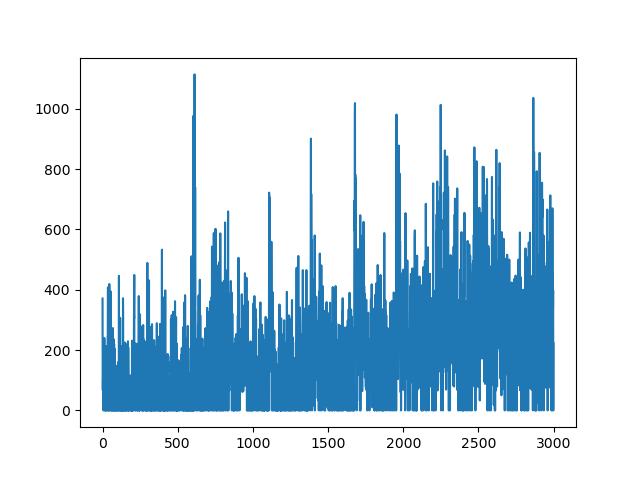

In [116]:
_, ax = plt.subplots()
ax.plot(binned_rips.time, binned_rips.firing_rate[0])

## High/Low USV/Ripple epoch plot

/tmp/ipykernel_284205/1711853227.py:22: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rect = Rectangle((start_time, 0.4), duration, 0.3, color='darkblue', edgecolor='none', alpha=0.7)
/tmp/ipykernel_284205/1711853227.py:31: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rect = Rectangle((start_time, 0.4), duration, 0.3, color='lightblue', edgecolor='none', alpha=0.5)
/tmp/ipykernel_284205/1711853227.py:37: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rect = Rectangle((start_time, 0.1), duration, 0.3, color='green', edgecolor='none', alpha=0.5)


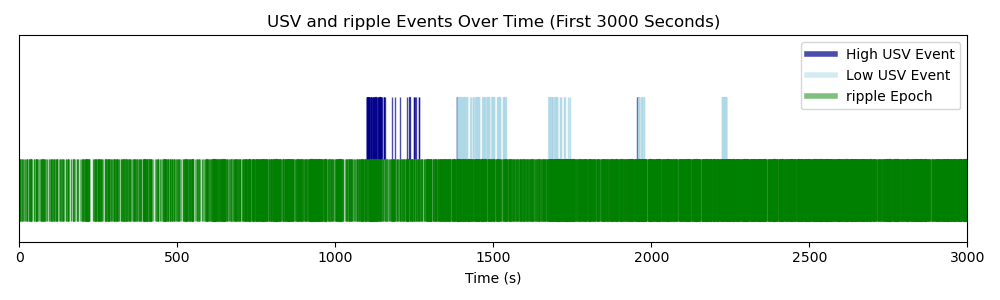

In [117]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

# Assuming ripple_epochs are defined elsewhere
ripple_start_times = ripple_epochs.starts
ripple_stop_times = ripple_epochs.stops
ripple_durations = ripple_stop_times - ripple_start_times

usv_start_times = usv_epochs.starts
usv_stop_times = usv_epochs.stops
usv_durations = usv_epochs.stops - usv_epochs.starts

fig, ax = plt.subplots(figsize=(10, 3))

# Plot high USV events in another color (now on top)
for _, row in highusv_epochs.iterrows():
    start_time = row['start']
    stop_time = row['stop']
    duration = stop_time - start_time
    if start_time <= 3000:  # Limit to the first 3000 seconds
        rect = Rectangle((start_time, 0.4), duration, 0.3, color='darkblue', edgecolor='none', alpha=0.7)
        ax.add_patch(rect)

# Plot low USV events in one color (now second from top)
for _, row in lowusv_epochs.iterrows():
    start_time = row['start']
    stop_time = row['stop']
    duration = stop_time - start_time
    if start_time <= 3000:  # Limit to the first 3000 seconds
        rect = Rectangle((start_time, 0.4), duration, 0.3, color='lightblue', edgecolor='none', alpha=0.5)
        ax.add_patch(rect)

# Plot ripple epochs (now third from top)
for start_time, duration in zip(ripple_start_times, ripple_durations):
    if start_time <= 3000:  # Limit to the first 3000 seconds
        rect = Rectangle((start_time, 0.1), duration, 0.3, color='green', edgecolor='none', alpha=0.5)
        ax.add_patch(rect)

# Customize the legend
custom_lines = [
    Line2D([0], [0], color='darkblue', lw=4, alpha=0.7),
    Line2D([0], [0], color='lightblue', lw=4, alpha=0.5),
    Line2D([0], [0], color='green', lw=4, alpha=0.5),
]
ax.legend(custom_lines, ['High USV Event', 'Low USV Event', 'ripple Epoch'])

# Adjust limits and labels
ax.set_xlim(0, 3000)  # Limit x-axis to the first 3000 seconds
ax.set_ylim(0, 1)  # Adjusted to accommodate all rows without overlapping
ax.set_xlabel('Time (s)')
ax.set_yticks([])
plt.title('USV and ripple Events Over Time (First 3000 Seconds)')
plt.tight_layout()
plt.show()

In [118]:
ripple_epochs.to_dataframe().peak_time.values

array([5.11200000e-01, 8.36800000e-01, 1.80880000e+00, ...,
       2.05791328e+04, 2.05793112e+04, 2.05797488e+04])

## Ripple CCGs

In [119]:
from neuropy.utils.ccg import correlograms

# We observe that right after ripple ends there seem to be a lot of USVs starting - check this by looking at CCG between ripple off and
# USV onset times
# ripple_off_usv_on_times = [ripple_epochs.stops, usv_epochs.starts]
ripple_off_usv_on_times = [ripple_epochs.to_dataframe().peak_time.values, usv_epochs.starts]
ripple_off_usv_on_ids = np.hstack([np.ones_like(array)*ida for ida, array in enumerate(ripple_off_usv_on_times)])
ripple_off_usv_on_times = np.hstack(ripple_off_usv_on_times)
sort_ids = np.argsort(ripple_off_usv_on_times)

ripple_off_usv_on_times = ripple_off_usv_on_times[sort_ids]
ripple_off_usv_on_ids = ripple_off_usv_on_ids[sort_ids].astype(int)

window_size = 10 # seconds
bin_size = 0.1 # seconds
ccg = correlograms(ripple_off_usv_on_times, ripple_off_usv_on_ids, sample_rate=30, window_size=window_size, bin_size=bin_size)

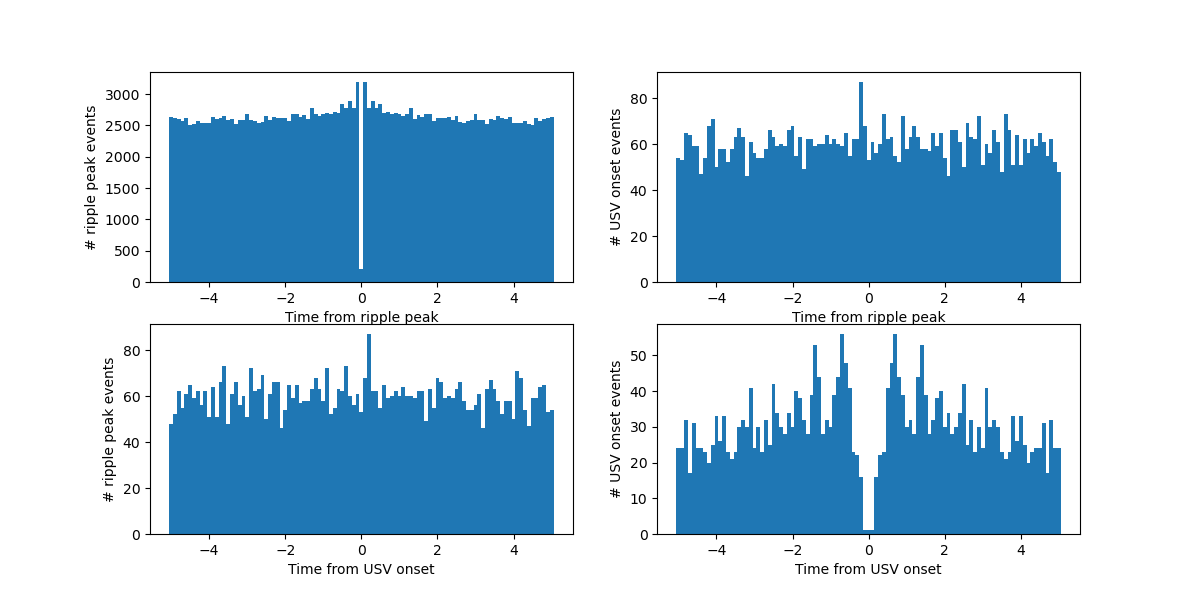

In [120]:
# Sample plotting code
time_bins = np.linspace(-window_size/2, window_size/2, np.array(window_size/bin_size + 1, dtype=int))
_, ax = plt.subplots(2, 2, figsize=(12, 6))

var_names = ['ripple peak', 'USV onset']
for idv, (a, ccg_use) in enumerate(zip(ax, ccg)):
    for ida2, (a2, ccg_use2) in enumerate(zip(a, ccg_use)): 
        a2.bar(time_bins, ccg_use2, width=bin_size)
        a2.set_xlabel(f"Time from {var_names[idv]}")
        a2.set_ylabel(f"# {var_names[ida2]} events")

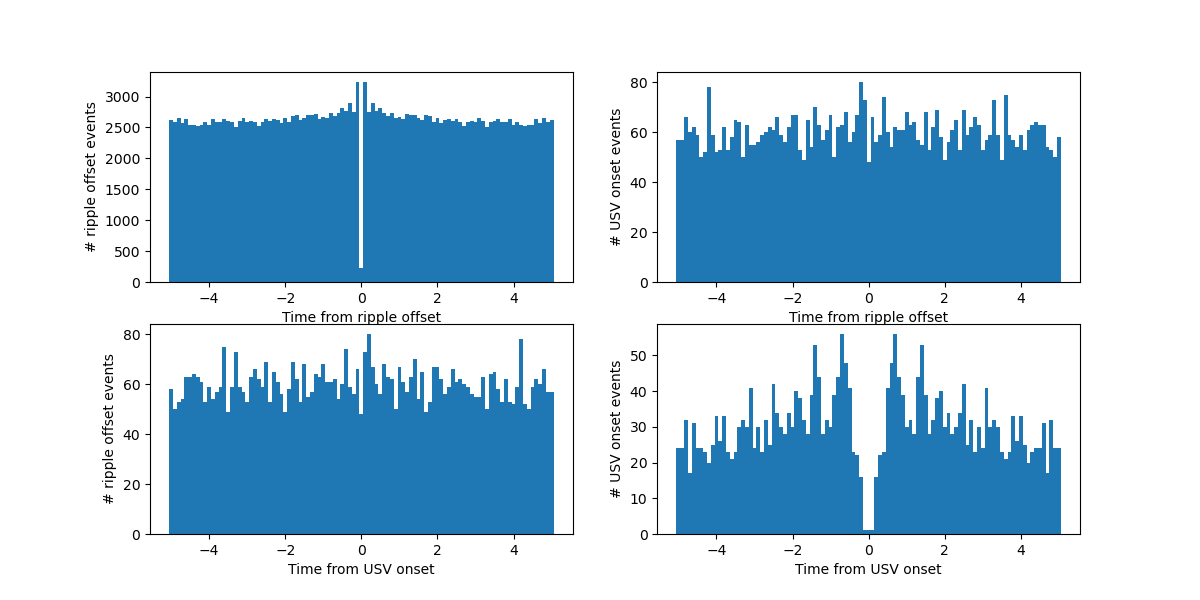

In [121]:
from neuropy.utils.ccg import correlograms

# We observe that right after ripple ends there seem to be a lot of USVs starting - check this by looking at CCG between ripple off and
# USV onset times
ripple_off_usv_on_times = [ripple_epochs.stops, usv_epochs.starts]
ripple_off_usv_on_ids = np.hstack([np.ones_like(array)*ida for ida, array in enumerate(ripple_off_usv_on_times)])
ripple_off_usv_on_times = np.hstack(ripple_off_usv_on_times)
sort_ids = np.argsort(ripple_off_usv_on_times)

ripple_off_usv_on_times = ripple_off_usv_on_times[sort_ids]
ripple_off_usv_on_ids = ripple_off_usv_on_ids[sort_ids].astype(int)

window_size = 10 # seconds
bin_size = 0.1 # seconds
ccg = correlograms(ripple_off_usv_on_times, ripple_off_usv_on_ids, sample_rate=30, window_size=window_size, bin_size=bin_size)
# Sample plotting code
time_bins = np.linspace(-window_size/2, window_size/2, np.array(window_size/bin_size + 1, dtype=int))
_, ax = plt.subplots(2, 2, figsize=(12, 6))

var_names = ['ripple offset', 'USV onset']
for idv, (a, ccg_use) in enumerate(zip(ax, ccg)):
    for ida2, (a2, ccg_use2) in enumerate(zip(a, ccg_use)): 
        a2.bar(time_bins, ccg_use2, width=bin_size)
        a2.set_xlabel(f"Time from {var_names[idv]}")
        a2.set_ylabel(f"# {var_names[ida2]} events")
fig.savefig('/home/bowenw/Documents/thesisplots/Django usv-ripple ccg all.png')

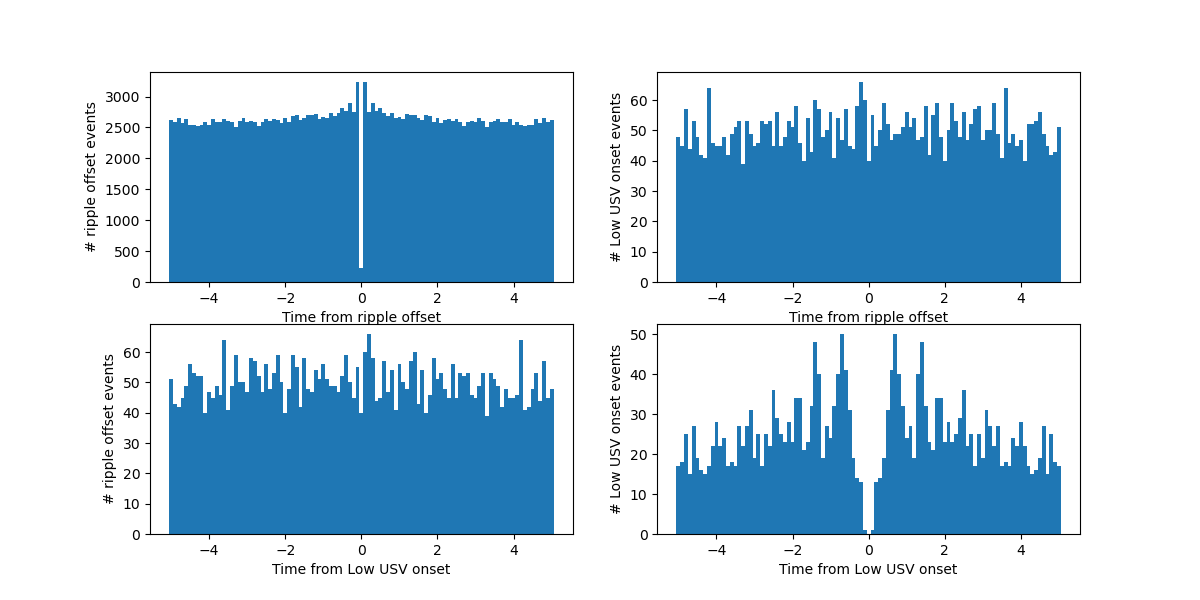

In [122]:
#low usv
from neuropy.utils.ccg import correlograms

# We observe that right after ripple ends there seem to be a lot of USVs starting - check this by looking at CCG between ripple off and
# USV onset times
ripple_off_lowusv_on_times = [ripple_epochs.stops, low_usv_epochs.start]
ripple_off_lowusv_on_ids = np.hstack([np.ones_like(array)*ida for ida, array in enumerate(ripple_off_lowusv_on_times)])
ripple_off_lowusv_on_times = np.hstack(ripple_off_lowusv_on_times)
sort_ids = np.argsort(ripple_off_lowusv_on_times)

ripple_off_lowusv_on_times = ripple_off_lowusv_on_times[sort_ids]
ripple_off_lowusv_on_ids = ripple_off_lowusv_on_ids[sort_ids].astype(int)

window_size = 10 # seconds
bin_size = 0.1 # seconds
ccg = correlograms(ripple_off_lowusv_on_times, ripple_off_lowusv_on_ids, sample_rate=30, window_size=window_size, bin_size=bin_size)
# Sample plotting code, low_usv
time_bins = np.linspace(-window_size/2, window_size/2, np.array(window_size/bin_size + 1, dtype=int))
_, ax = plt.subplots(2, 2, figsize=(12, 6))

var_names = ['ripple offset', 'Low USV onset']
for idv, (a, ccg_use) in enumerate(zip(ax, ccg)):
    for ida2, (a2, ccg_use2) in enumerate(zip(a, ccg_use)): 
        a2.bar(time_bins, ccg_use2, width=bin_size)
        a2.set_xlabel(f"Time from {var_names[idv]}")
        a2.set_ylabel(f"# {var_names[ida2]} events")
fig.savefig('/home/bowenw/Documents/thesisplots/Django usv-ripple ccg lowusv.png')

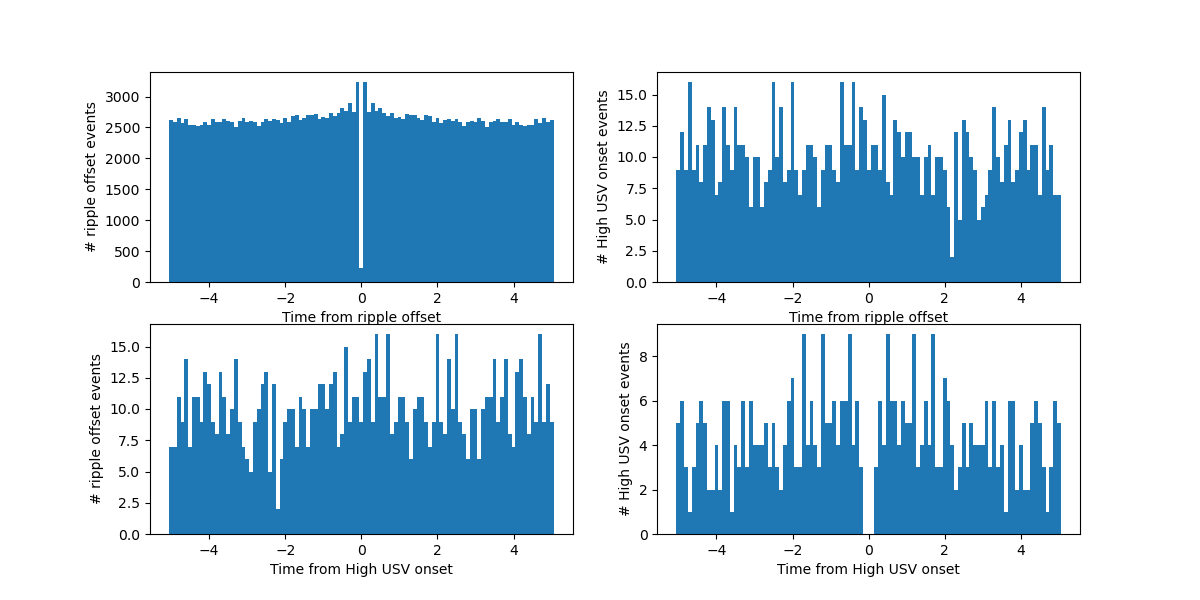

In [123]:
#high usv
from neuropy.utils.ccg import correlograms

# We observe that right after ripple ends there seem to be a lot of USVs starting - check this by looking at CCG between ripple off and
# USV onset times
ripple_off_highusv_on_times = [ripple_epochs.stops, high_usv_epochs.start]
ripple_off_highusv_on_ids = np.hstack([np.ones_like(array)*ida for ida, array in enumerate(ripple_off_highusv_on_times)])
ripple_off_highusv_on_times = np.hstack(ripple_off_highusv_on_times)
sort_ids = np.argsort(ripple_off_highusv_on_times)

ripple_off_highusv_on_times = ripple_off_highusv_on_times[sort_ids]
ripple_off_highusv_on_ids = ripple_off_highusv_on_ids[sort_ids].astype(int)

window_size = 10 # seconds
bin_size = 0.1 # seconds
ccg = correlograms(ripple_off_highusv_on_times, ripple_off_highusv_on_ids, sample_rate=30, window_size=window_size, bin_size=bin_size)
# Sample plotting code, low_usv
time_bins = np.linspace(-window_size/2, window_size/2, np.array(window_size/bin_size + 1, dtype=int))
_, ax = plt.subplots(2, 2, figsize=(12, 6))

var_names = ['ripple offset', 'High USV onset']
for idv, (a, ccg_use) in enumerate(zip(ax, ccg)):
    for ida2, (a2, ccg_use2) in enumerate(zip(a, ccg_use)): 
        a2.bar(time_bins, ccg_use2, width=bin_size)
        a2.set_xlabel(f"Time from {var_names[idv]}")
        a2.set_ylabel(f"# {var_names[ida2]} events")
fig.savefig('/home/bowenw/Documents/thesisplots/Django usv-ripple ccg highusv.png')

In [124]:
from neuropy.utils.ccg import correlograms
ripple_off_usv_on_times = [ripple_epochs.to_dataframe().peak_time.values, usv_epochs.stops]
ripple_off_usv_on_ids = np.hstack([np.ones_like(array)*ida for ida, array in enumerate(ripple_off_usv_on_times)])
ripple_off_usv_on_times = np.hstack(ripple_off_usv_on_times)
sort_ids = np.argsort(ripple_off_usv_on_times)

ripple_off_usv_on_times = ripple_off_usv_on_times[sort_ids]
ripple_off_usv_on_ids = ripple_off_usv_on_ids[sort_ids].astype(int)

window_size = 10 # seconds
bin_size = 0.1 # seconds
ccg = correlograms(ripple_off_usv_on_times, ripple_off_usv_on_ids, sample_rate=30, window_size=window_size, bin_size=bin_size)

## All ripple CCG together

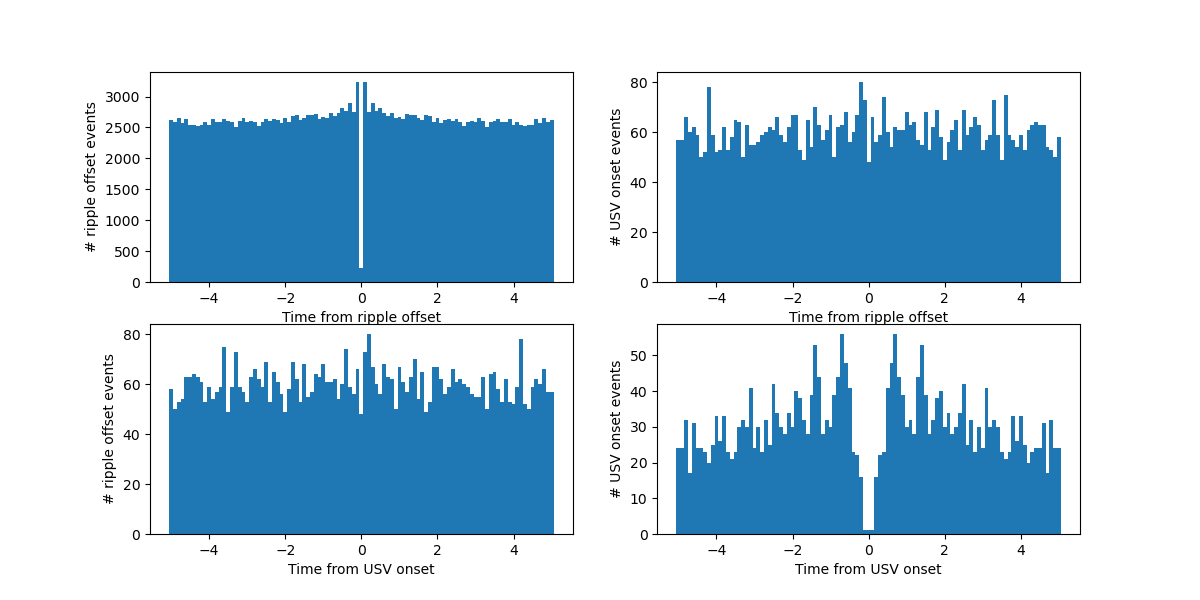

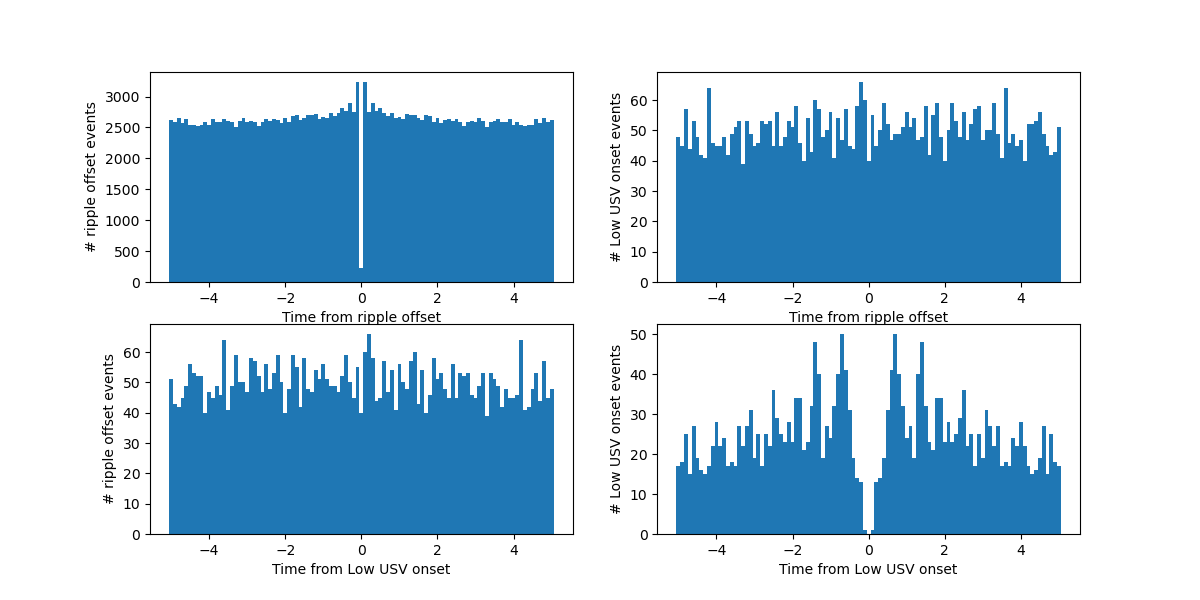

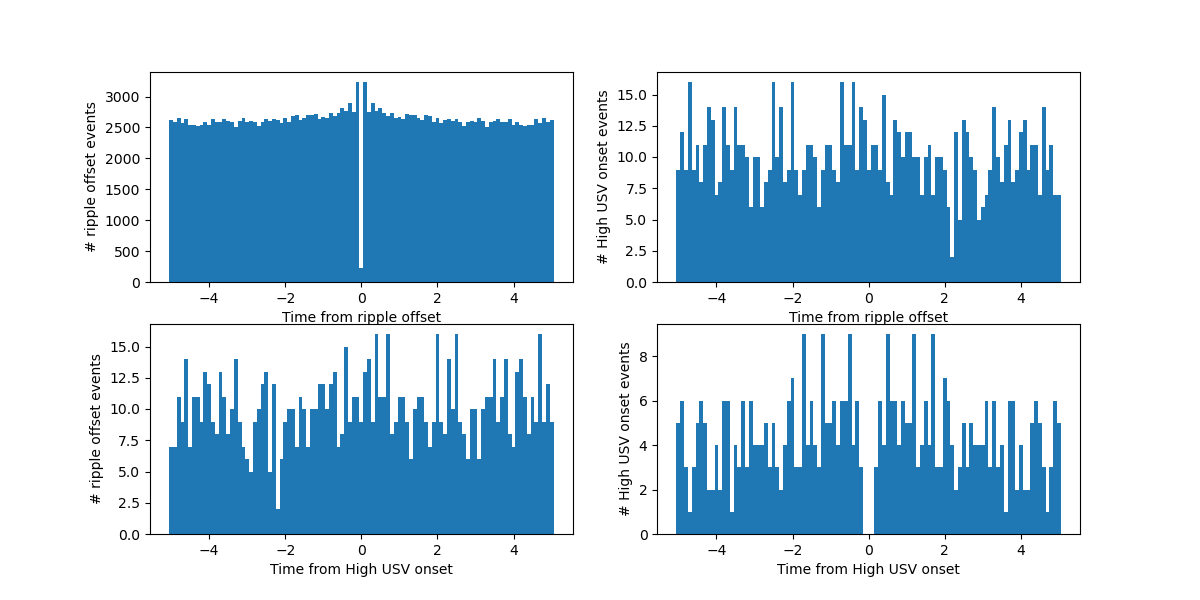

In [125]:
from neuropy.utils.ccg import correlograms

# We observe that right after ripple ends there seem to be a lot of USVs starting - check this by looking at CCG between ripple off and
# USV onset times
ripple_off_usv_on_times = [ripple_epochs.stops, usv_epochs.starts]
ripple_off_usv_on_ids = np.hstack([np.ones_like(array)*ida for ida, array in enumerate(ripple_off_usv_on_times)])
ripple_off_usv_on_times = np.hstack(ripple_off_usv_on_times)
sort_ids = np.argsort(ripple_off_usv_on_times)

ripple_off_usv_on_times = ripple_off_usv_on_times[sort_ids]
ripple_off_usv_on_ids = ripple_off_usv_on_ids[sort_ids].astype(int)

window_size = 10 # seconds
bin_size = 0.1 # seconds
ccg = correlograms(ripple_off_usv_on_times, ripple_off_usv_on_ids, sample_rate=30, window_size=window_size, bin_size=bin_size)
# Sample plotting code
time_bins = np.linspace(-window_size/2, window_size/2, np.array(window_size/bin_size + 1, dtype=int))
corr4_fig, ax = plt.subplots(2, 2, figsize=(12, 6))

var_names = ['ripple offset', 'USV onset']
for idv, (a, ccg_use) in enumerate(zip(ax, ccg)):
    for ida2, (a2, ccg_use2) in enumerate(zip(a, ccg_use)): 
        a2.bar(time_bins, ccg_use2, width=bin_size)
        a2.set_xlabel(f"Time from {var_names[idv]}")
        a2.set_ylabel(f"# {var_names[ida2]} events")
corr4_fig.savefig('/home/bowenw/Documents/thesisplots/Django usv-ripple ccg all.png')

#low usv
from neuropy.utils.ccg import correlograms

# We observe that right after ripple ends there seem to be a lot of USVs starting - check this by looking at CCG between ripple off and
# USV onset times
ripple_off_lowusv_on_times = [ripple_epochs.stops, lowusv_epochs.start]
ripple_off_lowusv_on_ids = np.hstack([np.ones_like(array)*ida for ida, array in enumerate(ripple_off_lowusv_on_times)])
ripple_off_lowusv_on_times = np.hstack(ripple_off_lowusv_on_times)
sort_ids = np.argsort(ripple_off_lowusv_on_times)

ripple_off_lowusv_on_times = ripple_off_lowusv_on_times[sort_ids]
ripple_off_lowusv_on_ids = ripple_off_lowusv_on_ids[sort_ids].astype(int)

window_size = 10 # seconds
bin_size = 0.1 # seconds
ccg = correlograms(ripple_off_lowusv_on_times, ripple_off_lowusv_on_ids, sample_rate=30, window_size=window_size, bin_size=bin_size)
# Sample plotting code, low_usv
time_bins = np.linspace(-window_size/2, window_size/2, np.array(window_size/bin_size + 1, dtype=int))
corr5_fig, ax = plt.subplots(2, 2, figsize=(12, 6))

var_names = ['ripple offset', 'Low USV onset']
for idv, (a, ccg_use) in enumerate(zip(ax, ccg)):
    for ida2, (a2, ccg_use2) in enumerate(zip(a, ccg_use)): 
        a2.bar(time_bins, ccg_use2, width=bin_size)
        a2.set_xlabel(f"Time from {var_names[idv]}")
        a2.set_ylabel(f"# {var_names[ida2]} events")
corr5_fig.savefig('/home/bowenw/Documents/thesisplots/Django usv-ripple ccg lowusv.png')

#high usv
from neuropy.utils.ccg import correlograms

# We observe that right after ripple ends there seem to be a lot of USVs starting - check this by looking at CCG between ripple off and
# USV onset times
ripple_off_highusv_on_times = [ripple_epochs.stops, highusv_epochs.start]
ripple_off_highusv_on_ids = np.hstack([np.ones_like(array)*ida for ida, array in enumerate(ripple_off_highusv_on_times)])
ripple_off_highusv_on_times = np.hstack(ripple_off_highusv_on_times)
sort_ids = np.argsort(ripple_off_highusv_on_times)

ripple_off_highusv_on_times = ripple_off_highusv_on_times[sort_ids]
ripple_off_highusv_on_ids = ripple_off_highusv_on_ids[sort_ids].astype(int)

window_size = 10 # seconds
bin_size = 0.1 # seconds
ccg = correlograms(ripple_off_highusv_on_times, ripple_off_highusv_on_ids, sample_rate=30, window_size=window_size, bin_size=bin_size)
# Sample plotting code, low_usv
time_bins = np.linspace(-window_size/2, window_size/2, np.array(window_size/bin_size + 1, dtype=int))
corr6_fig, ax = plt.subplots(2, 2, figsize=(12, 6))

var_names = ['ripple offset', 'High USV onset']
for idv, (a, ccg_use) in enumerate(zip(ax, ccg)):
    for ida2, (a2, ccg_use2) in enumerate(zip(a, ccg_use)): 
        a2.bar(time_bins, ccg_use2, width=bin_size)
        a2.set_xlabel(f"Time from {var_names[idv]}")
        a2.set_ylabel(f"# {var_names[ida2]} events")
corr6_fig.savefig('/home/bowenw/Documents/thesisplots/Django usv-ripple ccg highusv.png')

In [126]:
# Look at ripple peak vs USV offset

# Look at theta stop vs USV start (already done above)

# Look at theta start vs USV stop

## Useless codes

In [127]:
theta_buffer_sec = (2, 3)
wv_theta_mean = wv_theta.get_pe_mean_spec(theta_epochs.starts, buffer_sec=theta_buffer_sec)
ax = plot_spectrogram(wv_theta_mean, time_lims=np.multiply(theta_buffer_sec, (-1, 1)), freq_lims=theta_freq_lims)
ax.set_xlabel('Time from Theta epoch start (sec)')

NameError: name 'wv_theta' is not defined

In [ ]:
swr_range = np.arange(125, 275, 5)
wv_swr = WaveletSg(signal.time_slice(channel_id=ripple_channel, t_stop=np.min((80*60, signal.t_stop))), freqs=swr_range, sigma=None)

In [ ]:
# Sanity check code - does wavelet align well with actual SWR epochs?
_, ax = plt.subplots(2, 1, sharex=True, figsize=(9, 4))
time_to_plot = [0, 60]
swr_freq_lims = [130, 260]

plot_signal_w_epochs(signal, theta_channel, ripple_epochs, ax=ax[0])

plot_spectrogram(wv_swr, time_lims=time_to_plot, freq_lims=swr_freq_lims, ax=ax[1])

In [ ]:
delta_range = np.arange(0.5, 4.25, 0.1)
wv_delta = WaveletSg(signal.time_slice(channel_id=delta_channel, t_stop=np.min((80*60, signal.t_stop))), freqs=delta_range, sigma=None)

In [ ]:
_, ax = plt.subplots(2, 1, sharex=True, figsize=(9, 4))
time_to_plot = [0, 120]
delta_freq_lims = [0.5, 4]

plot_signal_w_epochs(signal, delta_channel, delta_epochs, ax=ax[0])

plot_spectrogram(wv_delta, time_lims=time_to_plot, freq_lims=delta_freq_lims, ax=ax[1])

In [ ]:
# Run wavelet on beta range
beta_range = np.arange(12, 40, 1)  # How do I select these? 
wv_beta = WaveletSg(signal.time_slice(channel_id=beta_channel, t_stop=np.min((80*60, signal.t_stop))), freqs=beta_range, sigma=None)

In [ ]:
_, ax = plt.subplots(2, 1, sharex=True, figsize=(9, 4))
time_to_plot = [0, 60]
beta_freq_lims = [12, 40]

plot_signal_w_epochs(signal, beta_channel, beta_epochs, ax=ax[0])

plot_spectrogram(wv_beta, time_lims=time_to_plot, freq_lims=beta_freq_lims, ax=ax[1])

In [ ]:
gamma_range = np.arange(40, 80, 1)
wv_gamma = WaveletSg(signal.time_slice(channel_id=gamma_channel, t_stop=np.min((80*60, signal.t_stop))), freqs=gamma_range, sigma=None)

In [ ]:
_, ax = plt.subplots(2, 1, sharex=True, figsize=(9, 4))
time_to_plot = [0, 60]
gamma_freq_lims = [40, 80]

plot_signal_w_epochs(signal, gamma_channel, gamma_epochs, ax=ax[0])

plot_spectrogram(wv_gamma, time_lims=time_to_plot, freq_lims=gamma_freq_lims, ax=ax[1])

In [ ]:
ripple_buffer_sec = (0.1, 0.1)
wv_swr_mean = wv_swr.get_pe_mean_spec(ripple_epochs.to_dataframe()['peak_time'].values, buffer_sec=ripple_buffer_sec)
ax = plot_spectrogram(wv_swr_mean, time_lims=np.multiply(ripple_buffer_sec, (-1, 1)), freq_lims=swr_freq_lims)
ax.set_xlabel('Time from Ripple Peak (sec)')

In [ ]:
# Import USV epochs (from Sync_USV_and_Ephys notebook).
usv_epochs_file = sess.filePrefix.with_suffix(".usv_epochs.npy")
usv_epochs = Epoch(epochs=None, file=usv_epochs_file)
usv_epochs


In [ ]:
usv_epochs._epochs

In [ ]:
usv_epochs._epochs.Duration.mean()

In [ ]:
short_usv_epochs = usv_epochs._epochs[usv_epochs._epochs.Duration<0.1]
short_usv_epochs

In [ ]:
short_usv_epochs.Duration.mean()

In [ ]:
long_usv_epochs_filtered = usv_epochs._epochs[(usv_epochs._epochs.Duration>1)]
long_usv_epochs_filtered

In [ ]:
art_epochs

In [ ]:
long_usv_epochs_filtered.Duration.mean()

In [ ]:
usv_epochs.n_epochs

In [ ]:
long_usv_epochs_filtered.shape

In [ ]:
short_usv_epochs.shape

In [ ]:
freq_thresh = 30
low_usvs = usv_epochs._epochs[usv_epochs._epochs.Freq_Min < freq_thresh]
low_usvs

In [ ]:
high_usvs = usv_epochs._epochs[usv_epochs._epochs.Freq_Min > freq_thresh]
high_usvs

In [ ]:
high_usvs.Duration.mean()